In [1]:
#pip install kneed # uncomment if you do not already have kneed installed
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut, LeavePOut, RepeatedKFold
from sklearn.model_selection import validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score
from sklearn.metrics import f1_score, classification_report, accuracy_score, plot_roc_curve, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator
from IPython.core.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')
pio.renderers.default = 'browser'

rand_state = 15941102
np.random.seed(15941102)

### Import data

In [2]:
ts = pd.read_csv('AUDL_team_game_logs_all.csv')
ps = pd.read_csv('AUDL_player_game_logs_all.csv')
divisions = pd.read_csv('divisions.csv')

### Clean team stats data


In [3]:
# Each game has stats for one team for the game in one row, and stats for the other team in another row.
# There are some games with stats for only one team. These 'singleton' games are removed.
game_counts = ts['gameID'].value_counts()
single_games = game_counts.index[game_counts!=2].values # 6 games are singletons
ts = ts[np.logical_not(ts['gameID'].isin(single_games))]

# Update teamID to be consistent (some teams change nicknames so using this as ID is not consistent)
ts['teamID'][ts['teamID'] == 'union'] = 'CHI'
ts['teamID'][ts['teamID'] == 'empire'] = 'NY'
ts['teamID'][ts['teamID'] == 'summit'] = 'COL'
ts['teamID'][ts['teamID'] == 'flyers'] = 'CAR'
ts['teamID'][ts['teamID'] == 'windchill'] = 'MIN'
ts['teamID'][ts['teamID'] == 'shred'] = 'SLC'
ts['teamID'][ts['teamID'] == 'breeze'] = 'DC'
ts['teamID'][ts['teamID'] == 'sol'] = 'ATX'
ts['teamID'][ts['teamID'] == 'growlers'] = 'SD'
ts['teamID'][ts['teamID'] == 'phoenix'] = 'PHI'
ts['teamID'][ts['teamID'] == 'alleycats'] = 'IND'
ts['teamID'][ts['teamID'] == 'mechanix'] = 'DET'
ts['teamID'][ts['teamID'] == 'cannons'] = 'TB'
ts['teamID'][ts['teamID'] == 'legion'] = 'DAL'
ts['teamID'][ts['teamID'] == 'nitro'] = 'POR'
ts['teamID'][ts['teamID'] == 'outlaws'] = 'OTT'
ts['teamID'][ts['teamID'] == 'spiders'] = 'OAK'
ts['teamID'][ts['teamID'] == 'hustle'] = 'ATL'
ts['teamID'][ts['teamID'] == 'aviators'] = 'LA'
ts['teamID'][ts['teamID'] == 'radicals'] = 'MAD'
ts['teamID'][ts['teamID'] == 'cascades'] = 'SEA'
ts['teamID'][ts['teamID'] == 'glory'] = 'BOS'
ts['teamID'][ts['teamID'] == 'thunderbirds'] = 'PIT'
ts['teamID'][ts['teamID'] == 'rush'] = 'TOR'
ts['teamID'][ts['teamID'] == 'royal'] = 'MTL'
ts['teamID'][ts['teamID'] == 'nightwatch'] = 'NSH'
ts['teamID'][ts['teamID'] == 'flamethrowers'] = 'SF'
ts['teamID'][ts['teamID'] == 'riptide'] = 'VAN'
ts['teamID'][ts['teamID'] == 'revolution'] = 'CIN'
ts['teamID'][ts['teamID'] == 'express'] = 'CHA'
ts['teamID'][ts['teamID'] == 'dragons'] = 'ROC'
ts['teamID'][ts['teamID'] == 'lions'] = 'SLL'

# remove first 2 rows since they are an all-star game and won't be used for analysis,
# remove team name column since we will be using teamID
ts = ts.iloc[2:].reset_index(drop = True).drop('teamName', axis = 1)

# Create new columns for coding which team is home or away
# Use that to create a team score and opponent score column (as opposed to home and away)
ts['year'] = ts['gameID'].str[:4].astype(int)
ts['hometeam'] = ts['gameID'].str.extract(r'([A-Z]+)[^-]*$')
ts['awayteam'] = ts['gameID'].str.extract(r'([A-Z]+)[^-]*-.*$')

# function which takes dataframe and the name of the team and year columns (as strings) and renames the teams
def rename_team_col(df, col, y_col):
    df[col][df[col] == 'AUS'] = 'ATX'
    df[col][(df[col] == 'SLC') & (df[y_col] == 2014)] = 'SLL'
    df[col][df[col] == 'SJ'] = 'OAK'
    df[col][df[col] == 'JAX'] = 'TB'
    df[col][df[col] == 'RAL'] = 'CAR' 
    
rename_team_col(ts, 'hometeam', 'year')
rename_team_col(ts, 'awayteam', 'year')
ts['Home0Away1'] = np.where(ts['teamID'] == ts['hometeam'], 0, 1)
ts['opp'] = np.where(ts['teamID'] == ts['hometeam'], ts['awayteam'], ts['hometeam'])

ts['scoreTeam'] = np.where(ts['Home0Away1'] == 0, ts['scoreHome'], ts['scoreAway'])
ts['scoreOpp'] = np.where(ts['Home0Away1'] == 0, ts['scoreAway'], ts['scoreHome'])

# Code who won/lost/tied (there are 2 tie games)
def winlosstie(x, y):
    return np.where(x > y, 1, np.where(x < y, 0, 0.5))

home_result = winlosstie(ts['scoreHome'], ts['scoreAway'])
ts['win1Loss0TieHalf'] = np.where(ts['Home0Away1'] == 0, home_result, 1-home_result)
ts = ts.drop(['scoreHome', 'scoreAway', 'hometeam', 'awayteam'], axis = 1)

# ts.to_csv('AUDL_team_game_logs_clean.csv', index = False)

### Clean player stats data

In [4]:
# update result column for ties (already set for win = 1 and loss = 0)
# update team IDs to match what is in team stats csv
ps['result'][ps['tm_score'] == ps['opp_score']] = 0.5
rename_team_col(ps, 'tm', 'year')
rename_team_col(ps, 'opp', 'year')

# add additional calculated statistics
ps['comp_pct'] = ps['completions'] / ps['throwsAttempted']
ps['catch_pct'] = ps['catches'] / (ps['catches'] + ps['drops'])
ps['turnovers'] = ps['stalls'] + ps['throwaways'] + ps['drops']
ps['avg_pull_ht'] = ps['recordedPullsHangtime'] / ps['recordedPulls']
ps['yds_per_att'] = ps['yardsThrown'] / ps['throwsAttempted']
ps['yds_per_catch'] = ps['yardsReceived'] / (ps['catches'] + ps['drops'])
ps['huck_pct'] = ps['hucksCompleted'] / ps['hucksAttempted']
ps['o_score_pct'] = ps['oPointsScored'] / ps['oPointsPlayed']
ps['d_score_pct'] = ps['dPointsScored'] / ps['dPointsPlayed']

# save cleaned file
# ps.to_csv('AUDL_player_game_logs_clean.csv', index = False)

### SECTION 2 - Inference (ANOVA / Tukey's HSD tests)

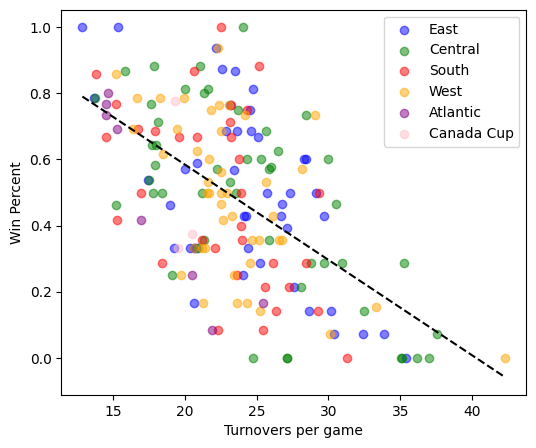

In [5]:
# add in division labels to each game
ts_div = ts.merge(divisions, how = 'inner', left_on = ('teamID', 'year'),
                  right_on = ('Team', 'Year')).drop(['Year', 'Team'], axis = 1)
ts_div = ts_div.merge(divisions, how = 'inner', left_on = ('opp', 'year'),
                       right_on = ('Team', 'Year'), suffixes = ('_tm', '_opp')).drop(['Year', 'Team'], axis = 1)
ts_plot = ts_div.groupby(['year', 'teamID', 'Rev_Division_tm']).agg({'turnovers': 'mean', 'win1Loss0TieHalf': 'mean', 'gameID': 'count'}).reset_index()
ts_plot.rename(columns = {'gameID': 'games', 'win1Loss0TieHalf': 'win_pct', 'turnovers': 'to_pg'}, inplace = True)

d = ('East', 'Central', 'South', 'West', 'Atlantic', 'Canada Cup')
hatchtype = {'East': '/', 'Central': '.', 'South': '\\', 'West': 'o', 'Atlantic': '-'}
color = {'East': 'Blue', 'Central': 'Green', 'South': 'Red', 'West': 'Orange', 'Atlantic': 'Purple',
         'Canada Cup': 'Pink'}

# plotting team win_pct against team turnovers per game
fig, ax = plt.subplots(figsize = (6, 5))
for i in d:
    ax.scatter(ts_plot[ts_plot['Rev_Division_tm'] == i]['to_pg'],
                ts_plot[ts_plot['Rev_Division_tm'] == i]['win_pct'],
                color = color[i], alpha = 0.5, label = i)

# getting best-fit line (seems like it should be steeper, just eyeballing it)
x = np.array(ts_plot['to_pg']).reshape(-1,1)
y = ts_plot['win_pct']
model = LinearRegression().fit(x, y)
    
xaxis = np.linspace(x.min(), x.max(), 1000)
yaxis = model.intercept_ + model.coef_ * xaxis
ax.plot(xaxis, yaxis, color = 'black', ls = '--')
ax.set(xlabel = 'Turnovers per game', ylabel = 'Win Percent')       
ax.legend();

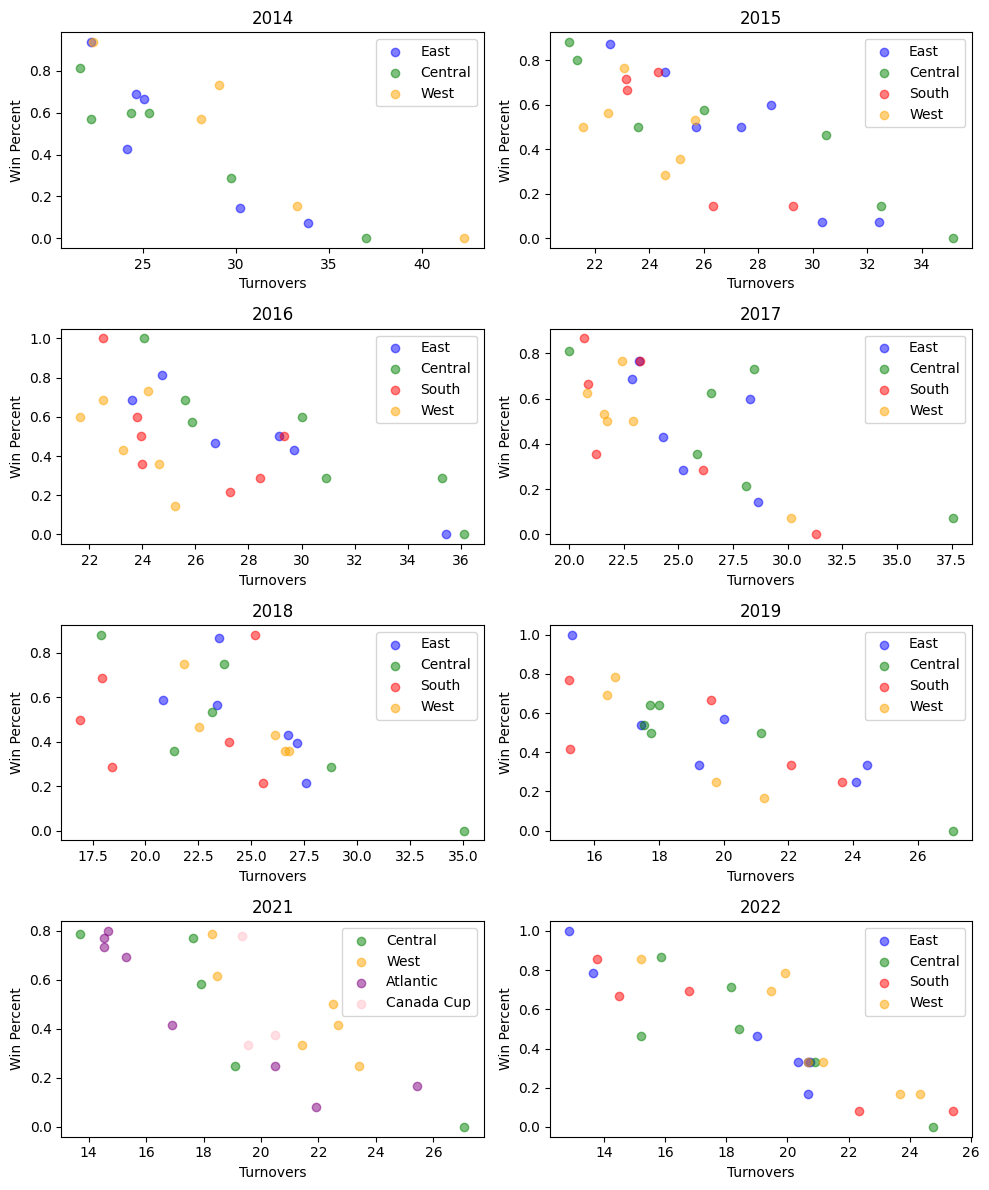

In [6]:
# plotting team win percent against team turnovers per game for each season separately

fig, ax = plt.subplots(4, 2, figsize = (10,12))
for i in d:
    j = 0
    for y in ts_plot['year'].unique():
        if (j + 1) % 2 != 0:
            a = 0
        else:
            a = 1
        if ts_plot[ts_plot['year'] == y]['Rev_Division_tm'].str.contains(i).any():
            ax[j//2, a].scatter(ts_plot[(ts_plot['Rev_Division_tm'] == i) & (ts_plot['year'] == y)]['to_pg'],
                                ts_plot[(ts_plot['Rev_Division_tm'] == i) & (ts_plot['year'] == y)]['win_pct'],
                                color = color[i], alpha = 0.5, label = i)
            ax[j//2, a].set(title = y, xlabel = 'Turnovers', ylabel = 'Win Percent')
            ax[j//2, a].legend()
        j += 1
fig.tight_layout();

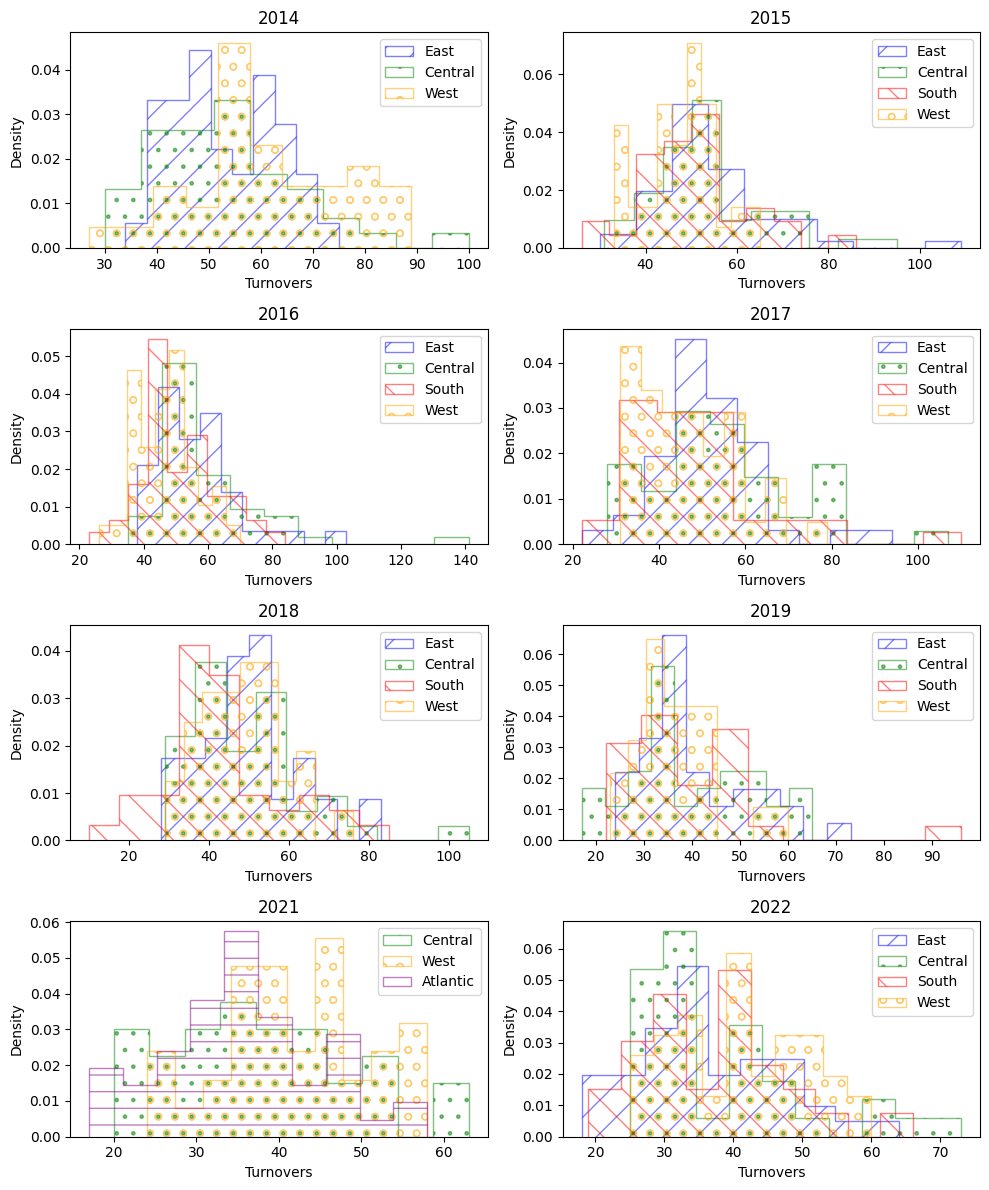

In [7]:
#  remove games where teams played non-divisonal opponents
ts_div = ts_div[ts_div['Rev_Division_tm'] == ts_div['Rev_Division_opp']].reset_index(drop = True)
ts_div = ts_div.groupby(['gameID', 'Rev_Division_tm', 'year']).sum().reset_index()
ts_div['comp_pct'] = ts_div['completions'] / ts_div['throwingAttempts']

# plotting histograms of turnovers in divisional games
fig, ax = plt.subplots(4, 2, figsize = (10,12))
d = d[:-1]
for i in d:
    j = 0
    for y in ts_div['year'].unique():
        if (j + 1) % 2 != 0:
            a = 0
        else:
            a = 1
        if ts_div[ts_div['year'] == y]['Rev_Division_tm'].str.contains(i).any():
            ax[j//2, a].hist(ts_div[(ts_div['Rev_Division_tm'] == i) & (ts_div['year'] == y)]['turnovers'],
                             bins = 10, density = True, histtype = 'step', hatch = hatchtype[i], color = color[i],
                             alpha = 0.5, label = i)
            ax[j//2, a].set(title = y, xlabel = 'Turnovers', ylabel = 'Density')
            ax[j//2, a].legend()
        j += 1
fig.tight_layout();

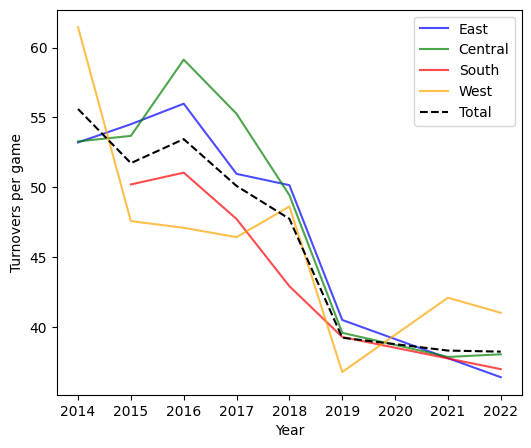

In [8]:
# group by and sum stats for each division each season
div_stats = ts_div.groupby(['Rev_Division_tm', 'year']).sum().reset_index()
div_stats['to_pg'] = div_stats['turnovers'] / div_stats['win1Loss0TieHalf']
div_stats['comp_pct'] = div_stats['completions'] / div_stats['throwingAttempts']

# plot turnovers per game for each division each season
d = d[:-1]
fig, ax = plt.subplots(figsize = (6, 5))
for i in d:
    ax.plot(div_stats[div_stats['Rev_Division_tm'] == i]['year'],
            div_stats[div_stats['Rev_Division_tm'] == i]['to_pg'], color = color[i], alpha = 0.7, label = i)

ax.plot(ts_div.groupby(['year'])['turnovers'].mean(), label = 'Total', ls = '--', color = 'black')
ax.set(xlabel = 'Year', ylabel = 'Turnovers per game')
ax.legend();

In [9]:
tm_turns = ts_div.groupby(['Rev_Division_tm', 'year']).agg({'turnovers': ['mean', 'std', 'count']}).reset_index()
tm_turns.droplevel(1, axis = 1)
tm_turns.columns = ['team', 'year', 'mean', 'std', 'n']
tm_turns['sem'] = 2 * tm_turns['std'] / np.sqrt(tm_turns['n'])
tm_turns

,team,year,mean,std,n,sem
0,Atlantic,2021,35.509804,9.250670,51,2.590706
1,Canada Cup,2021,39.538462,6.728241,13,3.732157
2,Central,2014,53.279070,14.221589,43,4.337544
3,Central,2015,53.673469,12.700702,49,3.628772
4,Central,2016,59.137255,16.432918,51,4.602137
5,Central,2017,55.255814,16.969290,43,5.175585
6,Central,2018,49.428571,14.760103,42,4.555067
7,Central,2019,39.567568,12.915410,37,4.246561
8,Central,2021,37.838710,11.141803,31,4.002254
9,Central,2022,38.028571,12.313278,35,4.162648


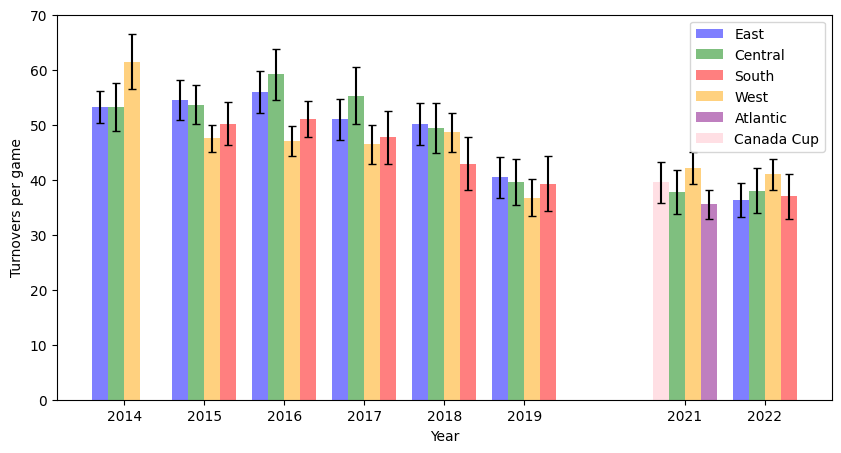

In [10]:
# creating bar plot for each division for each season with CI around mean number of turnovers
z = ('East', 'Central', 'South', 'West', 'Atlantic', 'Canada Cup')
x = np.arange(8)
width = 0.2

fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[0]]['year'] - 0.3,
       div_stats[div_stats['Rev_Division_tm'] == z[0]]['to_pg'], width,
       color = color[z[0]], alpha = 0.5, label = z[0], yerr = tm_turns[tm_turns['team'] == z[0]]['sem'], capsize = 3)
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[1]]['year'] - 0.1,
       div_stats[div_stats['Rev_Division_tm'] == z[1]]['to_pg'], width,
       color = color[z[1]], alpha = 0.5, label = z[1], yerr = tm_turns[tm_turns['team'] == z[1]]['sem'], capsize = 3)
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[2]]['year'] + 0.3,
       div_stats[div_stats['Rev_Division_tm'] == z[2]]['to_pg'], width,
       color = color[z[2]], alpha = 0.5, label = z[2], yerr = tm_turns[tm_turns['team'] == z[2]]['sem'], capsize = 3)
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[3]]['year'] + 0.1,
       div_stats[div_stats['Rev_Division_tm'] == z[3]]['to_pg'], width,
       color = color[z[3]], alpha = 0.5, label = z[3], yerr = tm_turns[tm_turns['team'] == z[3]]['sem'], capsize = 3)
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[4]]['year'] + 0.3,
       div_stats[div_stats['Rev_Division_tm'] == z[4]]['to_pg'], width,
       color = color[z[4]], alpha = 0.5, label = z[4], yerr = tm_turns[tm_turns['team'] == z[4]]['sem'], capsize = 3)
ax.bar(div_stats[div_stats['Rev_Division_tm'] == z[5]]['year'] - 0.3,
       div_stats[div_stats['Rev_Division_tm'] == z[5]]['to_pg'], width,
       color = color[z[5]], alpha = 0.5, label = z[5], yerr = tm_turns[tm_turns['team'] == z[5]]['sem'], capsize = 3)
ax.set_xticks(ticks = [2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022],
              labels = [2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022])
ax.set(xlabel = 'Year', ylabel = 'Turnovers per game', ylim = [0, 70])
ax.legend(fontsize = 10);

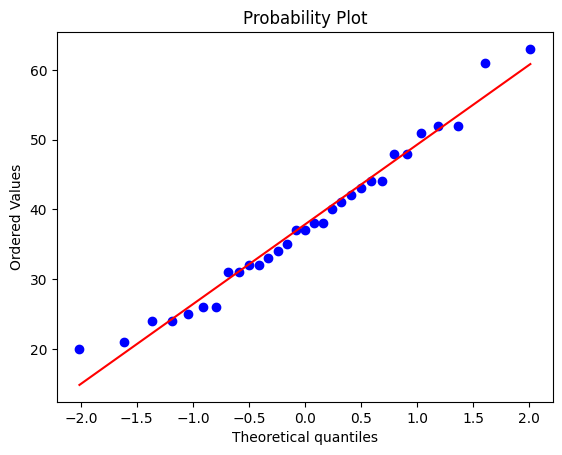

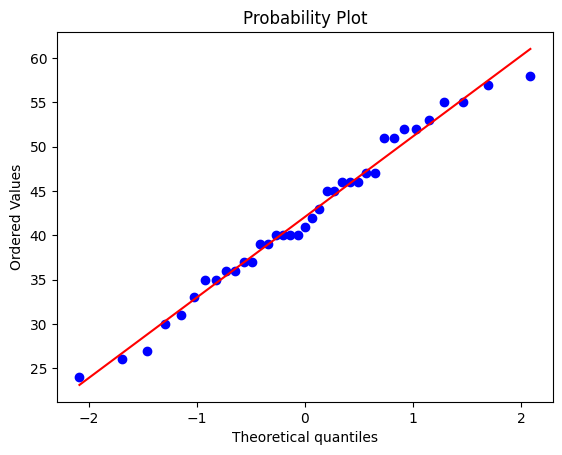

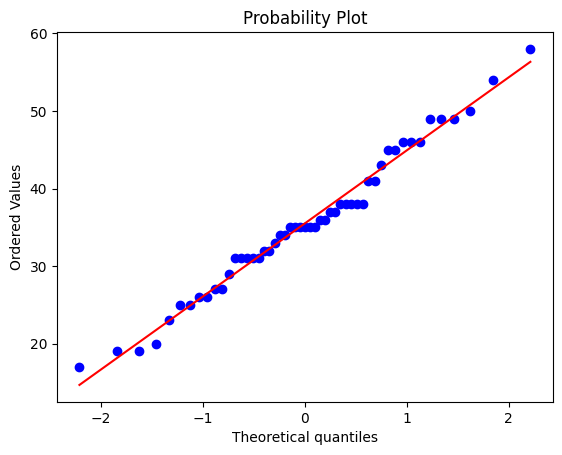

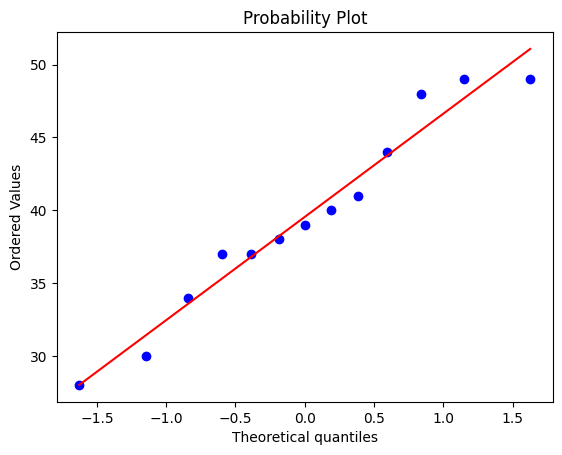

In [11]:
# check for normal distribution
for i in ts_div['Rev_Division_tm'].unique():
    stats.probplot(ts_div[(ts_div['Rev_Division_tm'] == i) & (ts_div['year'] == 2021)]['turnovers'],
                   dist = 'norm', plot = plt)
    plt.show()

In [12]:
# check for homogeneity of variance
homogeneity_of_var = []
for y in ts_div['year'].unique():
    homogeneity_of_var.append(ts_div[ts_div['year'] == y].groupby(['Rev_Division_tm'])['turnovers'].std().max() /
                             ts_div[ts_div['year'] == y].groupby(['Rev_Division_tm'])['turnovers'].std().min())

homogeneity_of_var

[1.5052615419005424,
 1.6231452122634111,
 1.7920764607977728,
 1.4550453925005227,
 1.5194022079532163,
 1.6348174060928615,
 1.6559756134850607,
 1.3023155046058708]

In [13]:
# ANOVA test - calculate f statistic, p value, and related statistics for each season to see if divisions are
# of different quality as measured by turnovers per game
# also run Levene test as another check of homogeneity of varience
anova = []
for y in ts_div['year'].unique():
    div_list = ts_div[ts_div['year'] == y]['Rev_Division_tm'].unique()
    a = ts_div[ts_div['year'] == y]['turnovers']
    a1 = ts_div[(ts_div['year'] == y) & (ts_div['Rev_Division_tm'] == div_list[0])]['turnovers']
    a2 = ts_div[(ts_div['year'] == y) & (ts_div['Rev_Division_tm'] == div_list[1])]['turnovers']
    a3 = ts_div[(ts_div['year'] == y) & (ts_div['Rev_Division_tm'] == div_list[2])]['turnovers']
    n1, n2, n3, n4 = len(a1), len(a2), len(a3), np.nan
    mu_total, mu1, mu2, mu3, mu4 = a.mean(), a1.mean(), a2.mean(), a3.mean(), np.nan
    ssw = np.sum((a1-mu1)**2) + np.sum((a2-mu2)**2) + np.sum((a3-mu3)**2)
    ssb = (mu1-mu_total)**2 * n1 + (mu2-mu_total)**2 * n2 + (mu3-mu_total)**2 * n3
    sst = np.sum((a - mu_total)**2)
    var1, var2, var3, var4 = a1.var(), a2.var(), a3.var(), np.nan
    N = n1 + n2 + n3
    if len(div_list) == 3:
        sp = np.sqrt(((n1-1)*var1 + (n2-1)*var2 + (n3-1)*var3) / (n1 + n2 + n3 - 3))
        lev = stats.levene(a1, a2, a3)[1]
        f, p = stats.f_oneway(a1, a2, a3)
    elif len(div_list) == 4:
        a4 = ts_div[(ts_div['year'] == y) & (ts_div['Rev_Division_tm'] == div_list[3])]['turnovers']
        n4, mu4, var4 = len(a4), a4.mean(), a4.var()
        N = N + n4
        ssw, ssb = ssw + np.sum((a4-mu4)**2), ssb + (mu4-mu_total)**2 * n4
        sp = np.sqrt(((n1-1)*var1 + (n2-1)*var2 + (n3-1)*var3 + (n4-1)*var4) / (N - 4))
        lev = stats.levene(a1, a2, a3, a4)[1]
        f, p = stats.f_oneway(a1, a2, a3, a4)
    
    eta_sq = ssb / sst
    cohen_f = np.sqrt(eta_sq / (1 - eta_sq))    
    anova.append(pd.DataFrame([(y, f, p, lev, N, n1, n2, n3, n4, mu1, mu2, mu3, mu4, sp, ssw, ssb, sst, eta_sq,
                                cohen_f)]))

results = pd.concat(anova, axis = 0).reset_index(drop = True)
results.rename(columns = {0: 'year', 1: 'f_stat', 2: 'p_value', 3: 'lev_value', 4: 'N', 5: 'n1', 6: 'n2', 7: 'n3',
                          8: 'n4', 9: 'mu1', 10: 'mu2', 11: 'mu3', 12: 'mu4', 13: 'sp', 14: 'ssw', 15: 'ssb',
                          16: 'sst', 17: 'eta_sq', 18: 'cohen_f'}, inplace = True)

In [14]:
# this code is to print a table with the ANOVA results for the report
'''table1 = go.Figure(data=[go.Table(
    header=dict(values=list(results[['year', 'f_stat', 'p_value', 'cohen_f']].columns), fill_color = 'lightcyan',
                line_color = 'darkslategray', align='left'),
    cells=dict(values=[results['year'], results['f_stat'], results['p_value'], results['cohen_f']],
               fill_color = 'white', line_color = 'darkslategrey', align = 'left'),
    columnwidth = (0.15, 0.15, 0.15, 0.15))
])
table1.update_layout(width=400, height=800)
table1.show()'''

"table1 = go.Figure(data=[go.Table(\n    header=dict(values=list(results[['year', 'f_stat', 'p_value', 'cohen_f']].columns), fill_color = 'lightcyan',\n                line_color = 'darkslategray', align='left'),\n    cells=dict(values=[results['year'], results['f_stat'], results['p_value'], results['cohen_f']],\n               fill_color = 'white', line_color = 'darkslategrey', align = 'left'),\n    columnwidth = (0.15, 0.15, 0.15, 0.15))\n])\ntable1.update_layout(width=400, height=800)\ntable1.show()"

In [15]:
# run Tukey HSD test post-hoc to figure out which groups are significantly different
tukey = []
for y in ts_div['year'].unique():
    new = pairwise_tukeyhsd(endog = ts_div[(ts_div['year'] == y)]['turnovers'],
                              groups = ts_div[(ts_div['year'] == y)]['Rev_Division_tm'], alpha=0.05)
    new_html = new.summary().as_html()
    new_df = pd.read_html(new_html, header = 0, index_col = 0)[0].reset_index()
    new_df.insert(0, 'year', y)
    tukey.append(new_df)

tukey = pd.concat(tukey, ignore_index = True, axis = 0)
tukey['lower_diff'] = tukey['meandiff'] - tukey['lower']
tukey['upper_diff'] = tukey['upper'] - tukey['meandiff']
tukey['group_comp'] = tukey['group1'] + '-' + tukey['group2']

In [16]:
# this code is to print a table with the Tukey HSD results for the report
'''tukey2 = tukey[tukey['year'] == 2021][['year', 'group1', 'group2', 'meandiff', 'p-adj']]
table1 = go.Figure(data=[go.Table(
    header=dict(values=list(tukey2.columns), fill_color = 'lightcyan',
                line_color = 'darkslategray', align='left'),
    cells=dict(values=[tukey2['year'], tukey2['group1'], tukey2['group2'], tukey2['meandiff'], tukey2['p-adj']],
               fill_color = 'white', line_color = 'darkslategrey', align = 'left'),
    columnwidth = (0.15, 0.25, 0.25, 0.15, 0.15))
])
table1.update_layout(width=600, height=800)
table1.show()'''

"tukey2 = tukey[tukey['year'] == 2021][['year', 'group1', 'group2', 'meandiff', 'p-adj']]\ntable1 = go.Figure(data=[go.Table(\n    header=dict(values=list(tukey2.columns), fill_color = 'lightcyan',\n                line_color = 'darkslategray', align='left'),\n    cells=dict(values=[tukey2['year'], tukey2['group1'], tukey2['group2'], tukey2['meandiff'], tukey2['p-adj']],\n               fill_color = 'white', line_color = 'darkslategrey', align = 'left'),\n    columnwidth = (0.15, 0.25, 0.25, 0.15, 0.15))\n])\ntable1.update_layout(width=600, height=800)\ntable1.show()"

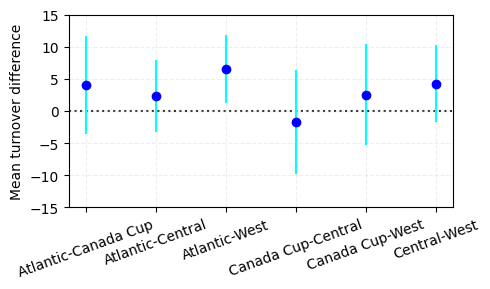

In [17]:
# plot confidence intervals of the mean turnover differences between divison pairs (per tukey HSD test)
# the CIs should not be compared to each other, just whether they touch 0.0, that's what shows significance
y = 2021
fig, ax = plt.subplots(figsize = (5, 3))
ax.errorbar(tukey[tukey['year'] == y]['meandiff'].index, tukey[tukey['year'] == y]['meandiff'],
            yerr = np.array(tukey[tukey['year'] == y][['lower_diff', 'upper_diff']]).T,
            fmt = 'o', color = 'blue', ecolor = 'cyan', zorder = 2)
ax.hlines(0, min(tukey[tukey['year'] == y]['meandiff'].index) - 0.25,
          max(tukey[tukey['year'] == y]['meandiff'].index) + 0.25, color = 'black', alpha = 0.8, ls = ':', zorder = 1)
ax.set_xticks(ticks = tukey[tukey['year'] == y]['group_comp'].index, 
              labels = tukey[tukey['year'] == y]['group_comp'].values, rotation = 20)
ax.set_ylabel('Mean turnover difference')
ax.set_ylim([-15, 15])
ax.margins(0, 0)
ax.grid(alpha=.2,linestyle='--')
fig.tight_layout()

### SECTION 3 - Prediction (logistic regression)

In [18]:
# Create a wide table with each game in one row, with data for both the Home (ends in 'H') and Away ('A') teams
ts2 = ts.copy()
ts2['date'] = pd.to_datetime(ts2['gameID'].str[:10])

# separate into individual dfs for each team each year and then get cumulative sums of all stats
# then combine back together in one df
individual_team_data = []
teams = ts2['teamID'].unique()
for t in teams:
    tdf = ts2[ts2['teamID'] == t].sort_values(by = 'date').reset_index(drop = True)
    tdf['b2b'] = np.where(tdf['date'] - tdf['date'].shift(1) < pd.to_timedelta(2, 'days'), 1, 0)
    tdf['compPct'] = tdf['completions'] / tdf['throwingAttempts']
    tdf['oLineHoldPct'] = tdf['oLineScores'] / tdf['oLinePoints']
    tdf['oLineScorePct'] = tdf['oLineScores'] / tdf['oLinePossessions']
    tdf['dLineBreakPct'] = tdf['dLineScores'] / tdf['dLinePoints']
    tdf['dLineScorePct'] = tdf['dLineScores'] / tdf['dLinePossessions']
    tdf['scoreDiff'] = tdf['scoreTeam'] - tdf['scoreOpp']
    tdf['dummy_count'] = 1
    for y in tdf['year'].unique():
        tdf2 = tdf[tdf['year'] == y].copy().reset_index(drop = True)
        tdf2['cum_completions'] = tdf2['completions'].shift(1).cumsum()
        tdf2['cum_throwingAttempts'] = tdf2['throwingAttempts'].shift(1).cumsum()
        tdf2['cum_blocks'] = tdf2['blocks'].shift(1).cumsum()
        tdf2['cum_turnovers'] = tdf2['turnovers'].shift(1).cumsum()
        tdf2['cum_oLineScores'] = tdf2['oLineScores'].shift(1).cumsum()
        tdf2['cum_oLinePoints'] = tdf2['oLinePoints'].shift(1).cumsum()
        tdf2['cum_oLinePossessions'] = tdf2['oLinePossessions'].shift(1).cumsum()
        tdf2['cum_dLineScores'] = tdf2['dLineScores'].shift(1).cumsum()
        tdf2['cum_dLinePoints'] = tdf2['dLinePoints'].shift(1).cumsum()
        tdf2['cum_dLinePossessions'] = tdf2['dLinePossessions'].shift(1).cumsum()
        tdf2['cum_scoreTeam'] = tdf2['scoreTeam'].shift(1).cumsum()
        tdf2['cum_scoreOpp'] = tdf2['scoreOpp'].shift(1).cumsum()
        tdf2['cum_compPct'] = tdf2['cum_completions'] / tdf2['cum_throwingAttempts']
        tdf2['cum_oLineHoldPct'] = tdf2['cum_oLineScores'] / tdf2['cum_oLinePoints']
        tdf2['cum_oLineScorePct'] = tdf2['cum_oLineScores'] / tdf2['cum_oLinePossessions']
        tdf2['cum_dLineBreakPct'] = tdf2['cum_dLineScores'] / tdf2['cum_dLinePoints']
        tdf2['cum_dLineScorePct'] = tdf2['cum_dLineScores'] / tdf2['cum_dLinePossessions']
        tdf2['cum_scoreDiff'] = tdf2['scoreDiff'].shift(1).cumsum()
        tdf2['cum_games'] = tdf2['dummy_count'].shift(1).cumsum()
        tdf2['cum_wins'] = tdf2['win1Loss0TieHalf'].shift(1).cumsum()
        tdf2['cum_completions_pg'] = tdf2['cum_completions'] / tdf2['cum_games']
        tdf2['cum_throwingAttempts_pg'] = tdf2['cum_throwingAttempts'] / tdf2['cum_games']
        tdf2['cum_blocks_pg'] = tdf2['cum_blocks'] / tdf2['cum_games']
        tdf2['cum_turnovers_pg'] = tdf2['cum_turnovers'] / tdf2['cum_games']
        tdf2['cum_oLineScores_pg'] = tdf2['cum_oLineScores'] / tdf2['cum_games']
        tdf2['cum_oLinePoints_pg'] = tdf2['cum_oLinePoints'] / tdf2['cum_games']
        tdf2['cum_oLinePossessions_pg'] = tdf2['cum_oLinePossessions'] / tdf2['cum_games']
        tdf2['cum_dLineScores_pg'] = tdf2['cum_dLineScores'] / tdf2['cum_games']
        tdf2['cum_dLinePoints_pg'] = tdf2['cum_dLinePoints'] / tdf2['cum_games']
        tdf2['cum_dLinePossessions_pg'] = tdf2['cum_dLinePossessions'] / tdf2['cum_games']
        tdf2['cum_winPct'] = tdf2['cum_wins'] / tdf2['cum_games']
        individual_team_data.append(tdf2)

df = pd.concat(individual_team_data, axis = 0)

In [19]:
# first game of the season for each team has NA for cumulative sum of all stats
# replace with 0 (for counting stats) or previous season's overall statistic for that team (for non-counting stats),
# or with overall average if it is the team's first season (for non-counting stats)

columns_to_fillzero = ['cum_completions', 'cum_throwingAttempts', 'cum_blocks', 'cum_turnovers', 'cum_oLineScores',
                       'cum_oLinePoints', 'cum_oLinePossessions', 'cum_dLineScores', 'cum_dLinePoints',
                       'cum_dLinePossessions', 'cum_scoreTeam', 'cum_scoreOpp', 'cum_scoreDiff', 'cum_games',
                       'cum_wins']
columns_to_ffill = ['cum_compPct', 'cum_oLineHoldPct', 'cum_oLineScorePct', 'cum_dLineBreakPct', 'cum_dLineScorePct',
                    'cum_completions_pg', 'cum_throwingAttempts_pg', 'cum_blocks_pg', 'cum_turnovers_pg',
                    'cum_oLineScores_pg', 'cum_oLinePoints_pg', 'cum_oLinePossessions_pg', 'cum_dLineScores_pg',
                    'cum_dLinePoints_pg', 'cum_dLinePossessions_pg']

for c in columns_to_fillzero:
    df[c].fillna(0, inplace = True)

df['cum_compPct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                             df['cum_compPct'],
                             np.where(df['teamID'] == df['teamID'].shift(1),
                                      (df['cum_completions'].shift(1) + df['completions'].shift(1)) / (df['cum_throwingAttempts'].shift(1) + df['throwingAttempts'].shift(1)),
                                      df['completions'].sum() / df['throwingAttempts'].sum()))
df['cum_oLineHoldPct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                  df['cum_oLineHoldPct'],
                                  np.where(df['teamID'] == df['teamID'].shift(1),
                                           (df['cum_oLineScores'].shift(1) + df['oLineScores'].shift(1)) / (df['cum_oLinePoints'].shift(1) + df['oLinePoints'].shift(1)),
                                           df['oLineScores'].sum() / df['oLinePoints'].sum()))
df['cum_oLineScorePct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                   df['cum_oLineScorePct'],
                                   np.where(df['teamID'] == df['teamID'].shift(1),
                                            (df['cum_oLineScores'].shift(1) + df['oLineScores'].shift(1)) / (df['cum_oLinePossessions'].shift(1) + df['oLinePossessions'].shift(1)),
                                            df['oLineScores'].sum() / df['oLinePossessions'].sum()))
df['cum_dLineBreakPct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                   df['cum_dLineBreakPct'],
                                   np.where(df['teamID'] == df['teamID'].shift(1),
                                            (df['cum_dLineScores'].shift(1) + df['dLineScores'].shift(1)) / (df['cum_dLinePoints'].shift(1) + df['dLinePoints'].shift(1)),
                                            df['dLineScores'].sum() / df['dLinePoints'].sum()))
df['cum_dLineScorePct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                   df['cum_dLineScorePct'],
                                   np.where(df['teamID'] == df['teamID'].shift(1),
                                            (df['cum_dLineScores'].shift(1) + df['dLineScores'].shift(1)) / (df['cum_dLinePossessions'].shift(1) + df['dLinePossessions'].shift(1)),
                                            df['dLineScores'].sum() / df['dLinePossessions'].sum()))
df['cum_completions_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                    df['cum_completions_pg'],
                                    np.where(df['teamID'] == df['teamID'].shift(1),
                                             (df['cum_completions'].shift(1) + df['completions'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                             df['completions'].sum() / df['dummy_count'].sum()))
df['cum_throwingAttempts_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                                         df['cum_throwingAttempts_pg'],
                                         np.where(df['teamID'] == df['teamID'].shift(1),
                                                  (df['cum_throwingAttempts'].shift(1) + df['throwingAttempts'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                                  df['throwingAttempts'].sum() / df['dummy_count'].sum()))
df['cum_blocks_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_blocks_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_blocks'].shift(1) + df['blocks'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['blocks'].sum() / df['dummy_count'].sum()))
df['cum_turnovers_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_turnovers_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_turnovers'].shift(1) + df['turnovers'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['turnovers'].sum() / df['dummy_count'].sum()))
df['cum_oLineScores_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_oLineScores_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_oLineScores'].shift(1) + df['oLineScores'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['oLineScores'].sum() / df['dummy_count'].sum()))
df['cum_oLinePoints_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_oLinePoints_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_oLinePoints'].shift(1) + df['oLinePoints'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['oLinePoints'].sum() / df['dummy_count'].sum()))
df['cum_oLinePossessions_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_oLinePossessions_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_oLinePossessions'].shift(1) + df['oLinePossessions'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['oLinePossessions'].sum() / df['dummy_count'].sum()))
df['cum_dLineScores_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_dLineScores_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_dLineScores'].shift(1) + df['dLineScores'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['dLineScores'].sum() / df['dummy_count'].sum()))
df['cum_dLinePoints_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_dLinePoints_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_dLinePoints'].shift(1) + df['dLinePoints'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['dLinePoints'].sum() / df['dummy_count'].sum()))
df['cum_dLinePossessions_pg'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['year'] == df['year'].shift(1)),
                               df['cum_dLinePossessions_pg'],
                               np.where(df['teamID'] == df['teamID'].shift(1),
                                        (df['cum_dLinePossessions'].shift(1) + df['dLinePossessions'].shift(1)) / (df['cum_games'].shift(1) + 1),
                                        df['dLinePossessions'].sum() / df['dummy_count'].sum()))
df['cum_winPct'] = np.where(df['teamID'] == df['teamID'].shift(1), df['cum_winPct'], np.nan)
df['cum_winPct'].fillna(0.5, inplace = True)

# add columns with the team's overall statistics for the previous season (so each game/data point has this info)
cols_to_fill = columns_to_fillzero[:-2]
for c in cols_to_fill:
    prev = 'prev_' + c[4:]
    c2 = c[4:]
    df[prev] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['cum_games'] == 0), df[c].shift(1) + df[c2],
                        np.where(df['teamID'] != df['teamID'].shift(1),
                                 df.groupby(['teamID', 'year'])[c2].sum().mean(), np.nan))
    df[prev].fillna(method = 'ffill', inplace = True)

for c in columns_to_ffill:
    prev = 'prev_' + c[4:]
    c2 = c[4:]
    df[prev] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['cum_games'] == 0), df[c],
                        np.where(df['teamID'] != df['teamID'].shift(1), df[c].iloc[0], np.nan))
    df[prev].fillna(method = 'ffill', inplace = True)

df['prev_winPct'] = np.where((df['teamID'] == df['teamID'].shift(1)) & (df['cum_games'] == 0),
                             (df['cum_wins'].shift(1) + df['win1Loss0TieHalf'].shift(1)) / (df['cum_games'].shift(1) + 1),
                             np.where(df['teamID'] != df['teamID'].shift(1), 0.5, np.nan))
df['prev_winPct'].fillna(method = 'ffill', inplace = True)

# add column with overall home team winning percent
df['home_winPct'] = df[df['Home0Away1'] == 0]['win1Loss0TieHalf'].mean()

# re-order columns for ease of viewing
column_order = ['gameID', 'year', 'date', 'teamID', 'Home0Away1', 'opp', 'scoreTeam', 'scoreOpp', 'scoreDiff',
                'win1Loss0TieHalf', 'b2b', 'completions', 'throwingAttempts', 'compPct', 'hucksCompleted','hucksAttempted',
                'blocks', 'turnovers', 'oLineScores', 'oLinePoints', 'oLineHoldPct', 'oLinePossessions',
                'oLineScorePct', 'dLineScores', 'dLinePoints', 'dLineBreakPct', 'dLinePossessions', 'dLineScorePct',
                'redZoneScores', 'redZonePossessions', 'cum_games', 'cum_scoreTeam', 'cum_scoreOpp', 'cum_scoreDiff',
                'cum_wins', 'cum_completions', 'cum_throwingAttempts', 'cum_compPct', 'cum_blocks', 'cum_turnovers',
                'cum_oLineScores', 'cum_oLinePoints', 'cum_oLineHoldPct', 'cum_oLinePossessions', 'cum_oLineScorePct',
                'cum_dLineScores', 'cum_dLinePoints', 'cum_dLineBreakPct', 'cum_dLinePossessions',
                'cum_dLineScorePct', 'cum_completions_pg', 'cum_throwingAttempts_pg', 'cum_blocks_pg',
                'cum_turnovers_pg', 'cum_oLineScores_pg', 'cum_oLinePoints_pg', 'cum_oLinePossessions_pg',
                'cum_dLineScores_pg', 'cum_dLinePoints_pg', 'cum_dLinePossessions_pg', 'cum_winPct',
                'prev_scoreTeam', 'prev_scoreOpp', 'prev_scoreDiff', 'prev_completions', 'prev_throwingAttempts',
                'prev_compPct', 'prev_blocks', 'prev_turnovers', 'prev_oLineScores', 'prev_oLinePoints',
                'prev_oLineHoldPct', 'prev_oLinePossessions', 'prev_oLineScorePct', 'prev_dLineScores',
                'prev_dLinePoints', 'prev_dLineBreakPct', 'prev_dLinePossessions', 'prev_dLineScorePct',
                'prev_completions_pg', 'prev_throwingAttempts_pg', 'prev_blocks_pg', 'prev_turnovers_pg',
                'prev_oLineScores_pg', 'prev_oLinePoints_pg', 'prev_oLinePossessions_pg', 'prev_dLineScores_pg',
                'prev_dLinePoints_pg', 'prev_dLinePossessions_pg', 'prev_winPct', 'home_winPct', 'dummy_count']
df = df[column_order]

#df.to_csv('full_team_data.csv', index = False)

In [20]:
# sort df, then split into home and away dataframes
# calculate differences and percentage differences between the 2 teams for all statistics
# re-combine so all info for each game is in one row
df = df.sort_values(by = ['gameID', 'Home0Away1']).reset_index(drop = True)

numeric_columns = ['b2b', 'cum_games', 'cum_scoreTeam', 'cum_scoreOpp', 'cum_scoreDiff', 'cum_wins',
                   'cum_completions', 'cum_throwingAttempts', 'cum_compPct', 'cum_blocks', 'cum_turnovers',
                   'cum_oLineScores', 'cum_oLinePoints', 'cum_oLineHoldPct', 'cum_oLinePossessions',
                   'cum_oLineScorePct', 'cum_dLineScores', 'cum_dLinePoints', 'cum_dLineBreakPct',
                   'cum_dLinePossessions', 'cum_dLineScorePct', 'cum_completions_pg', 'cum_throwingAttempts_pg',
                   'cum_blocks_pg', 'cum_turnovers_pg', 'cum_oLineScores_pg', 'cum_oLinePoints_pg',
                   'cum_oLinePossessions_pg', 'cum_dLineScores_pg', 'cum_dLinePoints_pg', 'cum_dLinePossessions_pg',
                   'cum_winPct', 'prev_scoreTeam', 'prev_scoreOpp', 'prev_scoreDiff', 'prev_completions',
                   'prev_throwingAttempts', 'prev_compPct', 'prev_blocks', 'prev_turnovers', 'prev_oLineScores',
                   'prev_oLinePoints', 'prev_oLineHoldPct', 'prev_oLinePossessions', 'prev_oLineScorePct',
                   'prev_dLineScores', 'prev_dLinePoints', 'prev_dLineBreakPct', 'prev_dLinePossessions',
                   'prev_dLineScorePct', 'prev_completions_pg', 'prev_throwingAttempts_pg', 'prev_blocks_pg',
                   'prev_turnovers_pg', 'prev_oLineScores_pg', 'prev_oLinePoints_pg', 'prev_oLinePossessions_pg',
                   'prev_dLineScores_pg', 'prev_dLinePoints_pg', 'prev_dLinePossessions_pg', 'prev_winPct']

df_home_games = df[df['Home0Away1'] == 0].copy().reset_index(drop = True)
df_away_games = df[df['Home0Away1'] == 1].copy().reset_index(drop = True)
diffs = (df_home_games[numeric_columns] - df_away_games[numeric_columns]).add_suffix('_diffHA')
pct_diffs = ((df_home_games[numeric_columns] - df_away_games[numeric_columns]) / df_home_games[numeric_columns]).add_suffix('_diffpctHA')
pct_diffs.fillna(0, inplace = True)
pct_diffs = pct_diffs.replace(-np.inf, -1)
pct_diffs = pct_diffs.replace(np.inf, 1)

df_home_games = df_home_games.drop(['opp', 'scoreOpp', 'Home0Away1', 'home_winPct', 'dummy_count'],
                                   axis = 1).reset_index(drop = True).add_suffix('_H')
df_away_games = df_away_games.drop(['gameID', 'year', 'date', 'opp', 'scoreOpp', 'Home0Away1'],
                                   axis = 1).reset_index(drop = True).add_suffix('_A')

ts_wideHA = pd.concat([df_home_games, df_away_games, diffs, pct_diffs], axis = 1)
ts_wideHA.rename(columns = {'gameID_H': 'gameID', 'year_H': 'year', 'date_H': 'date', 'home_winPct_A': 'home_winPct',
                            'dummy_count_A': 'dummy_count'}, inplace = True)

#ts_wideHA.to_csv('AUDL_team_game_wideHA.csv', index = False)

In [21]:
# remove rows from 2014 (since we don't have previous season's stats to use as predictors) and tie games
AUDL_team_game_wideHA_past = ts_wideHA.copy()
y_col = ['win1Loss0TieHalf_H']
AUDL_no2014 = AUDL_team_game_wideHA_past[AUDL_team_game_wideHA_past['year'] != 2014]
AUDL_no2014 = AUDL_no2014[(AUDL_no2014[y_col] != 0.5).values]

# create 80/20 train/test split
AUDL_team_game_wideHA_past_rand_train, AUDL_team_game_wideHA_past_rand_test = train_test_split(AUDL_no2014, train_size = 0.8, shuffle = True, random_state = rand_state)

In [22]:
x_cols = [col for col in AUDL_team_game_wideHA_past.columns.values if ("cum" in col or "prev" in col) and ("pg" in col or "Pct" in col)]
len(x_cols)
y_col = ['win1Loss0TieHalf_H']

# function to scale predictor variables in both train and test sets
def cols_to_xy_traintest_rand(x_cols, y_col, scale = True):
    x_train = AUDL_team_game_wideHA_past_rand_train[x_cols]
    x_test = AUDL_team_game_wideHA_past_rand_test[x_cols]
    y_train = AUDL_team_game_wideHA_past_rand_train[y_col]
    y_test = AUDL_team_game_wideHA_past_rand_test[y_col]
    if scale == True:
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    y_train_flat = y_train.values.flatten()
    y_test_flat = y_test.values.flatten()
    return x_train, y_train_flat, x_test, y_test_flat

# function for logistic regression and displaying results
def logistic_fit_results(clf, x_train_scaled, y_train_flat, x_test_scaled, y_test_flat, x_cols = x_cols):
    test_prob = clf.predict_proba(x_test_scaled)[:, 1]
    test_pred = clf.predict(x_test_scaled)
    logloss = log_loss(y_test_flat, test_prob)
    print('Log loss = {:.5f}'.format(log_loss(y_test_flat, test_prob)))
    AUC = roc_auc_score(y_test_flat, test_prob)
    print('AUC = {:.5f}'.format(roc_auc_score(y_test_flat, test_prob)))
    AP = average_precision_score(y_test_flat, test_prob)
    print('Average Precision = {:.5f}'.format(average_precision_score(y_test_flat, test_prob)))
    print('\nUsing 0.5 as threshold:')
    Accuracy = accuracy_score(y_test_flat, test_pred)
    print('Accuracy = {:.5f}'.format(accuracy_score(y_test_flat, test_pred)))
    precision = precision_score(y_test_flat, test_pred)
    print('Precision = {:.5f}'.format(precision_score(y_test_flat, test_pred)))
    recall = recall_score(y_test_flat, test_pred)
    print('Recall = {:.5f}'.format(recall_score(y_test_flat, test_pred)))
    f1 = f1_score(y_test_flat, test_pred)
    print('F1 score = {:.5f}'.format(f1_score(y_test_flat, test_pred)))

    print('\nClassification Report')
    print(classification_report(y_test_flat, test_pred))

    random_classifier=np.linspace(0.0, 1.0, 100)
    
    fig, ax = plt.subplots(1, 3, figsize = (10, 4))
    fig.tight_layout()
    ax[0].plot(random_classifier, random_classifier, 'r--')
    RocCurveDisplay.from_estimator(clf, x_test_scaled, y_test_flat, ax = ax[0])
  
    random_classifier=np.linspace(0.0, 1.0, 100)
    baseline = np.repeat(y_test_flat.mean(),100)
    ax[1].plot(random_classifier, baseline, 'r--')
    PrecisionRecallDisplay.from_estimator(clf, x_test_scaled, y_test_flat, ax = ax[1])

    ConfusionMatrixDisplay.from_estimator(clf, x_test_scaled, y_test_flat, ax = ax[2])
    
    ax[0].legend(loc = 4, fontsize = 8)
    ax[1].legend(loc = 1, fontsize = 8)

    coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
    coef_df = pd.DataFrame(data={'variable': ['intercept'] + x_cols, 'coefficient': coefficients})
    display(coef_df.sort_values("coefficient"))
    
    return logloss, AUC, AP, Accuracy, precision, recall, f1, coef_df

Log loss = 0.50861
AUC = 0.81559
Average Precision = 0.84548

Using 0.5 as threshold:
Accuracy = 0.77489
Precision = 0.77703
Recall = 0.85821
F1 score = 0.81560

Classification Report
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71        97
         1.0       0.78      0.86      0.82       134

    accuracy                           0.77       231
   macro avg       0.77      0.76      0.76       231
weighted avg       0.77      0.77      0.77       231



,variable,coefficient
121,prev_turnovers_pg_diffpctHA,-0.494530
74,cum_oLineScores_pg_diffHA,-0.272150
37,cum_dLineScorePct_A,-0.255897
80,cum_winPct_diffHA,-0.226189
44,cum_oLinePossessions_pg_A,-0.158954
...,...,...
72,cum_blocks_pg_diffHA,0.285544
112,cum_winPct_diffpctHA,0.313441
101,cum_dLineScorePct_diffpctHA,0.318587
0,intercept,0.432748


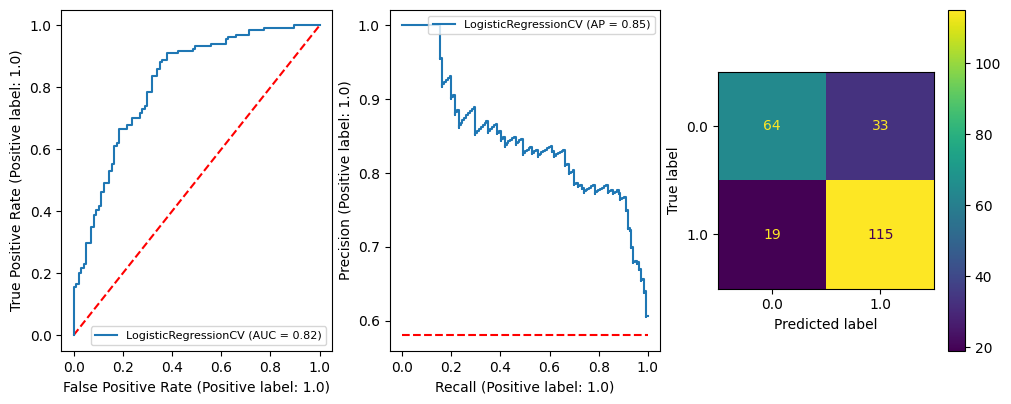

In [23]:
# run regression and display results
x_train_scaled, y_train_flat, x_test_scaled, y_test_flat = cols_to_xy_traintest_rand(x_cols,y_col)
clf = LogisticRegressionCV(Cs = 10, penalty = 'l1', solver = 'liblinear', max_iter = 400)
clf.fit(x_train_scaled, y_train_flat)
C = clf.C_[0]
logloss, AUC, AP, Accuracy, precision, recall, f1, coef_df = logistic_fit_results(clf, x_train_scaled, y_train_flat,
                                                                         x_test_scaled, y_test_flat, x_cols)

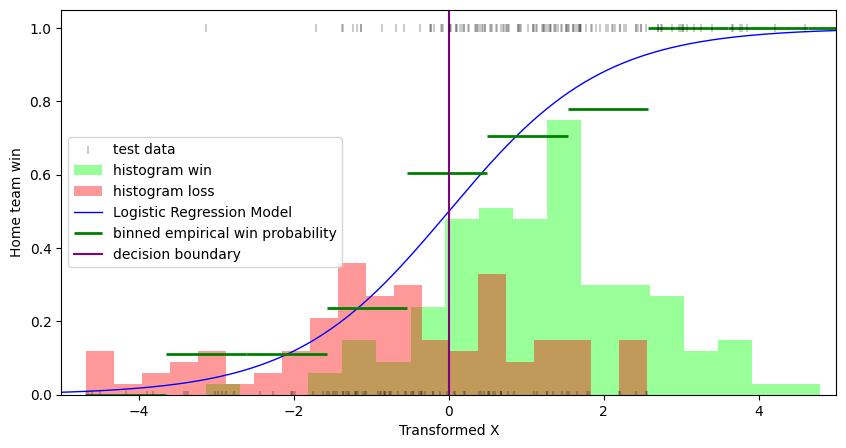

In [24]:
# transform and plot logistic function
results_list = []
short_desc = "AllColumnsL1CV"
long_desc = "Last, Current Season All Stats L1 CV"
results_list.append([short_desc,long_desc, C, logloss, AUC, AP, Accuracy, precision, recall, f1])
test_prob = clf.predict_proba(x_test_scaled)[:, 1]
test_pred = clf.predict(x_test_scaled)

lintransform = np.array(clf.coef_) @ np.array(x_test_scaled).T + clf.intercept_
lintransform = lintransform[0]

bin_means, bin_edges, binnumber = stats.binned_statistic(lintransform, y_test_flat,
        statistic='mean', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(1, figsize=(10, 5))
plt.clf()

plt.scatter(lintransform, y_test_flat, label="test data", color="black", zorder=20,marker = "|", alpha =0.2)
X_linspace = np.linspace(-5, 5, 300)

plt.hist(lintransform[y_test_flat == 1],density= False,bins = 20,fc=(0, 1, 0, 0.4), \
         weights=0.03*np.ones_like(lintransform[y_test_flat == 1]), label = "histogram win")

plt.hist(lintransform[y_test_flat == 0],density= False,bins = 20,fc=(1, 0, 0, 0.4), \
         weights=0.03*np.ones_like(lintransform[y_test_flat == 0]), label = 'histogram loss')


loss = expit(X_linspace).ravel()
plt.plot(X_linspace, loss, label="Logistic Regression Model", color="blue", linewidth=1)

plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
           label='binned empirical win probability')

plt.axvline(x = 0, color = "purple", label = 'decision boundary')


plt.xlim(-5, 5)
plt.xlabel("Transformed X")
plt.ylabel("Home team win")
plt.legend(loc = 6)
plt.show()

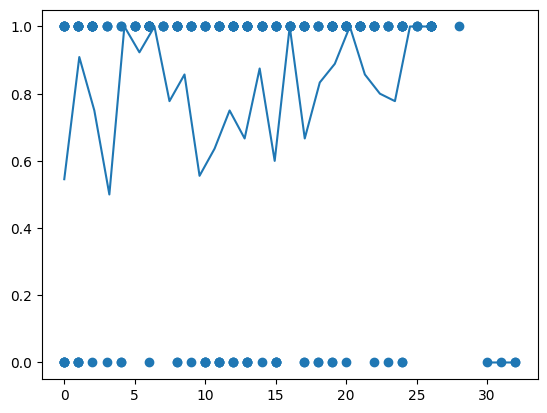

In [25]:
# checking if model is more likely to predict later games within a season correctly than earlier games
correct = (test_pred == y_test_flat).astype(int)
sum_cum_games = AUDL_team_game_wideHA_past_rand_test['cum_games_H'] + AUDL_team_game_wideHA_past_rand_test['cum_games_A']
ls = np.linspace(min(sum_cum_games), max(sum_cum_games), 31)
avg = []
count = []
for i in ls:
    avg.append(np.mean(correct[np.logical_and(sum_cum_games >= i, sum_cum_games < i+1)]))
    count.append(len(correct[np.logical_and(sum_cum_games >= i, sum_cum_games < i+1)]))
    
plt.scatter(sum_cum_games,correct)
plt.plot(ls,avg)

In [26]:
# this code prints prediction results in a table for the report
'''rt = pd.DataFrame(data = results_list, columns = ["Short Desc","Long Desc","RegPenaltyC", "logloss",
                                                  "AUC", "AP", "accuracy", "precision", "recall", "F1"])
rt['Long Desc'] = 'All rate stats, previous and current seasons, L1 CV'
rt.rename(columns = {'Long Desc': 'Model'}, inplace = True)
rt = rt.round(4)
table1 = go.Figure(data=[go.Table(
    header=dict(values=list(rt[['Model', 'RegPenaltyC', 'logloss', 'AUC', 'AP', 'accuracy',
                                'precision', 'recall', 'F1']].columns), fill_color = 'lightcyan',
                line_color = 'darkslategray', align='left'),
    cells=dict(values=[rt['Model'], rt['RegPenaltyC'], rt['logloss'], rt['AUC'], rt['AP'],
                       rt['accuracy'], rt['precision'], rt['recall'], rt['F1']],
               fill_color = 'white', line_color = 'darkslategrey', align = 'left'),
    columnwidth = (0.5, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2))
])
table1.update_layout(width = 1000, height = 400)
table1.show()'''

'rt = pd.DataFrame(data = results_list, columns = ["Short Desc","Long Desc","RegPenaltyC", "logloss",\n                                                  "AUC", "AP", "accuracy", "precision", "recall", "F1"])\nrt[\'Long Desc\'] = \'All rate stats, previous and current seasons, L1 CV\'\nrt.rename(columns = {\'Long Desc\': \'Model\'}, inplace = True)\nrt = rt.round(4)\ntable1 = go.Figure(data=[go.Table(\n    header=dict(values=list(rt[[\'Model\', \'RegPenaltyC\', \'logloss\', \'AUC\', \'AP\', \'accuracy\',\n                                \'precision\', \'recall\', \'F1\']].columns), fill_color = \'lightcyan\',\n                line_color = \'darkslategray\', align=\'left\'),\n    cells=dict(values=[rt[\'Model\'], rt[\'RegPenaltyC\'], rt[\'logloss\'], rt[\'AUC\'], rt[\'AP\'],\n                       rt[\'accuracy\'], rt[\'precision\'], rt[\'recall\'], rt[\'F1\']],\n               fill_color = \'white\', line_color = \'darkslategrey\', align = \'left\'),\n    columnwidth = (0.5, 0.25, 0.2,

### SECTION 4 - Classification (k-means clustering)

In [27]:
AUDL_player_data = ps.copy()
AUDL_player_level = AUDL_player_data.groupby('playerID').agg(np.mean)

# calculate overall averages, calculate additional stats
min_points_pitch = 20
AUDL_player_recent = AUDL_player_data[AUDL_player_data['year'] >= 2020]
AUDL_player_level_recent = AUDL_player_recent.groupby('playerID').agg(np.mean)

drop_recent = ['year','isHome', 'result', 'tm_score', 'opp_score', 'o_score_pct', 'd_score_pct', 'huck_pct']
AUDL_train_recent = AUDL_player_level_recent.drop(columns = drop_recent) 
AUDL_train_recent['number of matches played'] = AUDL_player_recent.groupby('playerID').agg({'year':'count'})
AUDL_train_recent['tot_opoints_pitch'] = AUDL_player_recent.groupby('playerID').agg({'oPointsPlayed':'sum'})
AUDL_train_recent['tot_dpoints_pitch'] = AUDL_player_recent.groupby('playerID').agg({'dPointsPlayed':'sum'})
AUDL_train_recent['tot_opoints_scored'] = AUDL_player_recent.groupby('playerID').agg({'oPointsScored':'sum'})
AUDL_train_recent['tot_dpoints_scored'] = AUDL_player_recent.groupby('playerID').agg({'dPointsScored':'sum'})

AUDL_train_recent['tot_points_pitch'] = AUDL_train_recent.loc[:,['tot_opoints_pitch',
                                                                 'tot_dpoints_pitch']].sum(axis = 1)
AUDL_train_recent['tot_points_scored'] = AUDL_train_recent.loc[:,['tot_opoints_scored',
                                                                  'tot_dpoints_scored']].sum(axis = 1)

AUDL_train_recent['o_pct'] = AUDL_train_recent['tot_opoints_scored'] /  AUDL_train_recent['tot_opoints_pitch']
AUDL_train_recent['d_pct'] = AUDL_train_recent['tot_dpoints_scored'] /  AUDL_train_recent['tot_dpoints_pitch']
AUDL_train_recent['ovd'] = AUDL_train_recent['tot_opoints_scored'] /  AUDL_train_recent['tot_points_scored']
AUDL_train_recent['huck_pct'] = AUDL_train_recent['hucksCompleted'] /  AUDL_train_recent['hucksAttempted']

# specify min points played for a player to be considered
min_points_pitch = 20
AUDL_train_recent_minp = AUDL_train_recent[AUDL_train_recent['tot_points_pitch'] >= min_points_pitch]

# fill missing values
mean_value_o_recent = AUDL_train_recent_minp['o_pct'].mean()
AUDL_train_recent_minp['o_pct'].fillna(value = mean_value_o_recent, inplace=True)

mean_value_d_recent = AUDL_train_recent_minp['d_pct'].mean()
AUDL_train_recent_minp['d_pct'].fillna(value = mean_value_d_recent, inplace=True)

AUDL_train_recent_minp['huck_pct'].fillna(value = 0, inplace=True)
AUDL_train_recent_minp['avg_pull_ht'].fillna(value = 0, inplace=True)
AUDL_recent_final = AUDL_train_recent_minp.dropna()

### PCA

In [28]:
scaler = MinMaxScaler()
AUDL_scaled_recent = pd.DataFrame(scaler.fit_transform(AUDL_recent_final))
AUDL_scaled_recent.columns = AUDL_recent_final.columns

n_components1 = AUDL_recent_final.shape[1]
pca = PCA(n_components = n_components1, random_state = rand_state)
pca.fit(AUDL_scaled_recent)

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
lst = []
for i in range (0, n_components1):
    lst.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']

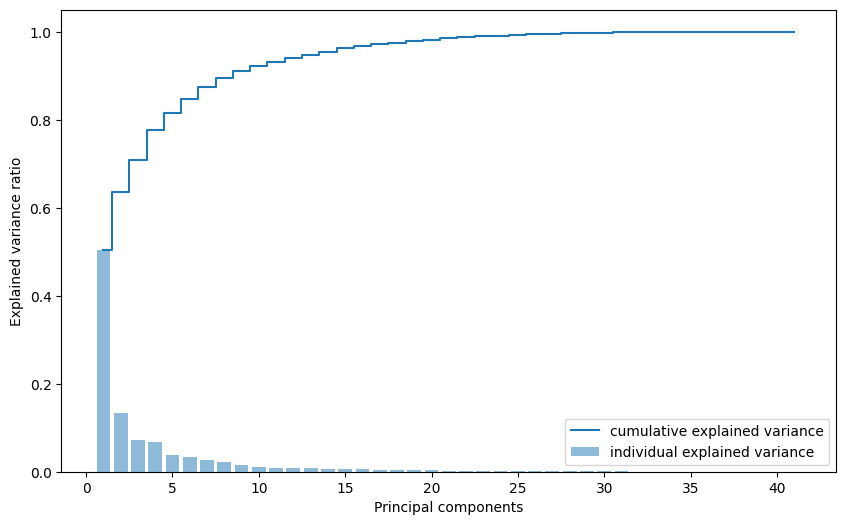

In [29]:
# plot PCA results
plt.subplots(figsize=(10,6))

plt.bar(pca_predictor['Component'], pca_predictor['Explained Variance'], align = 'center', alpha = 0.5, 
       label = 'individual explained variance')
plt.step(pca_predictor['Component'], pca_predictor['Cumulative Explained Variance'], where = 'mid',
         label = 'cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc = 'best')

In [30]:
pca = PCA(n_components = 9)
pca.fit(AUDL_scaled_recent)

PC = range(1, pca.n_components_ + 1)
PCnames = ['PC' + str(i + 1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_.reshape(41, 9),columns = PCnames,index = AUDL_scaled_recent.columns)
Loadings['Max'] = Loadings.idxmax(axis = 1)

AUDL_transformed_recent = pca.fit_transform(AUDL_scaled_recent)

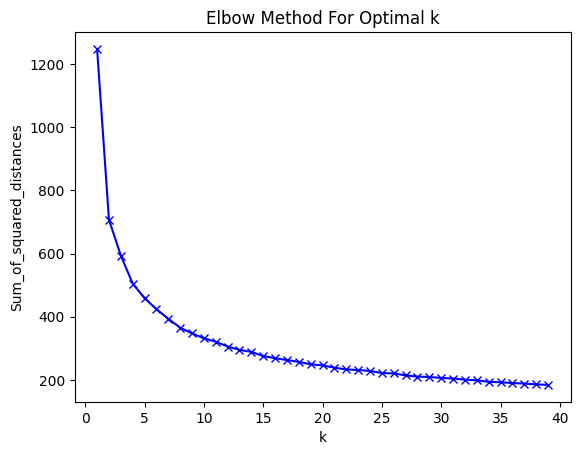

In [31]:
# run k-means clustering
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(AUDL_transformed_recent)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

8


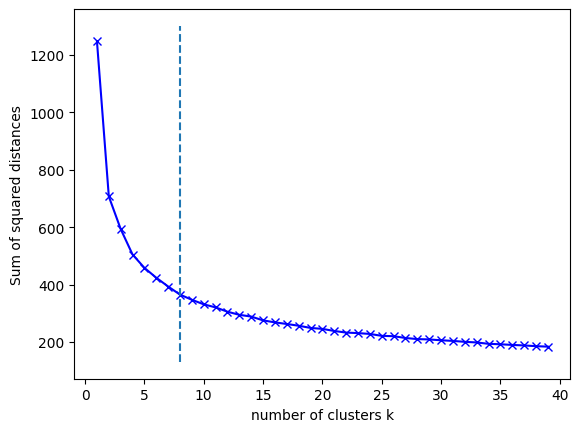

In [32]:
# finding optimal number of clusters
x = range(1, len(Sum_of_squared_distances) + 1)

kn = KneeLocator(x, Sum_of_squared_distances, curve = 'convex', direction = 'decreasing')
print(kn.knee)

plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, Sum_of_squared_distances, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles = 'dashed')

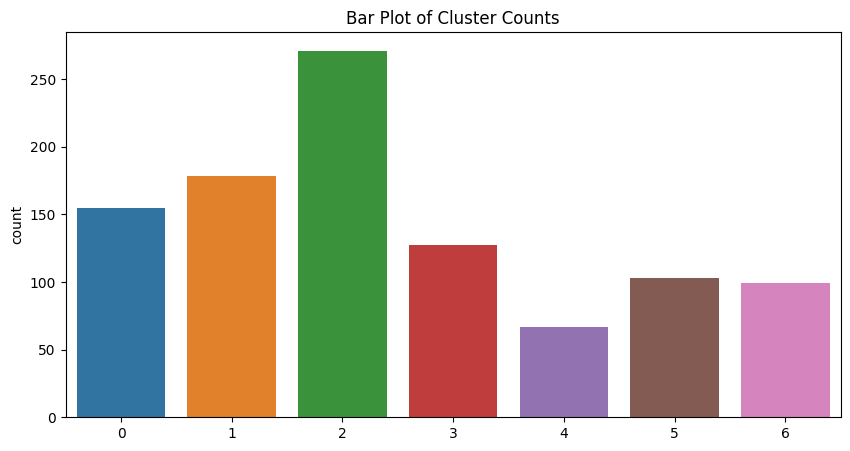

In [33]:
n_clusters = 7 # from our Kneedle method
kmeans = KMeans(n_clusters = n_clusters, random_state = rand_state)
kmeans.fit(AUDL_transformed_recent)

cluster_labels = kmeans.labels_
AUDL_recent_final['cluster'] = cluster_labels # AUDL player level data doesnt have labels

# plot cluster sizes
ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(cluster_labels)
title = "Bar Plot of Cluster Counts"
ax.set_title(title, fontsize = 12)
plt.show()

In [34]:
# checking variable to PCA component mapping and taking representative variables for clustering
f_value = []
p_value = []
column_value=[]
for y in list(AUDL_recent_final.columns):
    cluster_list = AUDL_recent_final['cluster'].unique()
    f, p = stats.f_oneway(AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[0])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[1])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[2])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[3])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[4])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[5])][y],
                          AUDL_recent_final[(AUDL_recent_final['cluster'] == cluster_list[6])][y],)
    f_value.append(f)
    p_value.append(p)
    column_value.append(y)

d1 = {'Columns' : column_value, 'p value':p_value}
col_clus_anova = pd.DataFrame(d1)

col_pc1 = ['blocks', 'oPointsScored']
col_pc2 = ['drops']
col_pc3 = []
col_pc4 = ['yds_per_att', 'o_pct', 'ovd', 'throwaways', 'hockeyAssists']
col_pc5 = ['yardsReceived', 'yardsThrown']
col_pc6 = ['pulls', 'yds_per_catch', 'huck_pct']
col_pc7 = []
col_pc8 = ['assists', 'goals', 'hucksAttempted']
col_pc9 = ['catches', 'd_pct', 'turnovers']
final_cols = col_pc1 + col_pc2 + col_pc3 + col_pc4 + col_pc5 + col_pc6 + col_pc7 + col_pc8 + col_pc9

AUDL_reduced = AUDL_recent_final[final_cols]

In [35]:
scaler = MinMaxScaler()
AUDL_scaled_reduced = pd.DataFrame(scaler.fit_transform(AUDL_reduced))
AUDL_scaled_reduced.columns = AUDL_reduced.columns

n_components2 = AUDL_reduced.shape[1]
pca = PCA(n_components = n_components2, random_state = rand_state)
pca.fit(AUDL_scaled_reduced)

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
lst = []
for i in range (0, n_components2):
    lst.append([i + 1, round(explained_variance_ratio[i], 6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']

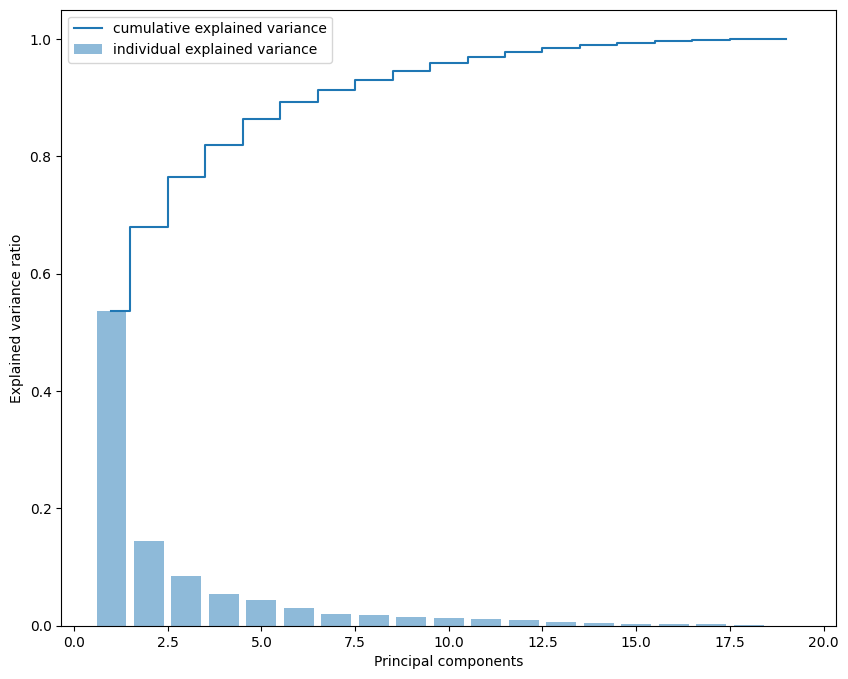

In [36]:
plt.subplots(figsize = (10, 8))

plt.bar(pca_predictor['Component'], pca_predictor['Explained Variance'], align='center', alpha = 0.5, 
       label = 'individual explained variance')
plt.step(pca_predictor['Component'], pca_predictor['Cumulative Explained Variance'], where = 'mid',
         label = 'cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc = 'best')

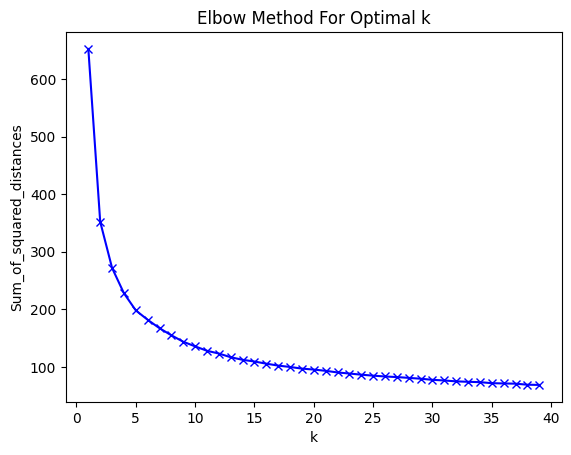

In [37]:
pca = PCA(n_components = 6, random_state = rand_state)
pca.fit(AUDL_scaled_reduced)

AUDL_transformed_reduced = pca.fit_transform(AUDL_scaled_reduced)
AUDL_transformed_reduced.shape

Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(AUDL_transformed_reduced)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

6


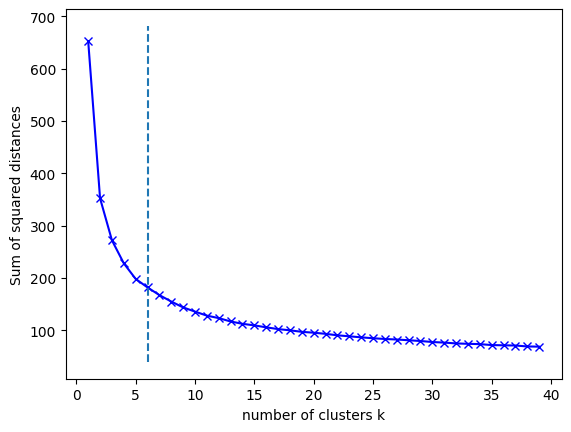

In [38]:
x = range(1, len(Sum_of_squared_distances) + 1)

kn = KneeLocator(x, Sum_of_squared_distances, curve = 'convex', direction = 'decreasing')
print(kn.knee)

plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, Sum_of_squared_distances, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles = 'dashed')

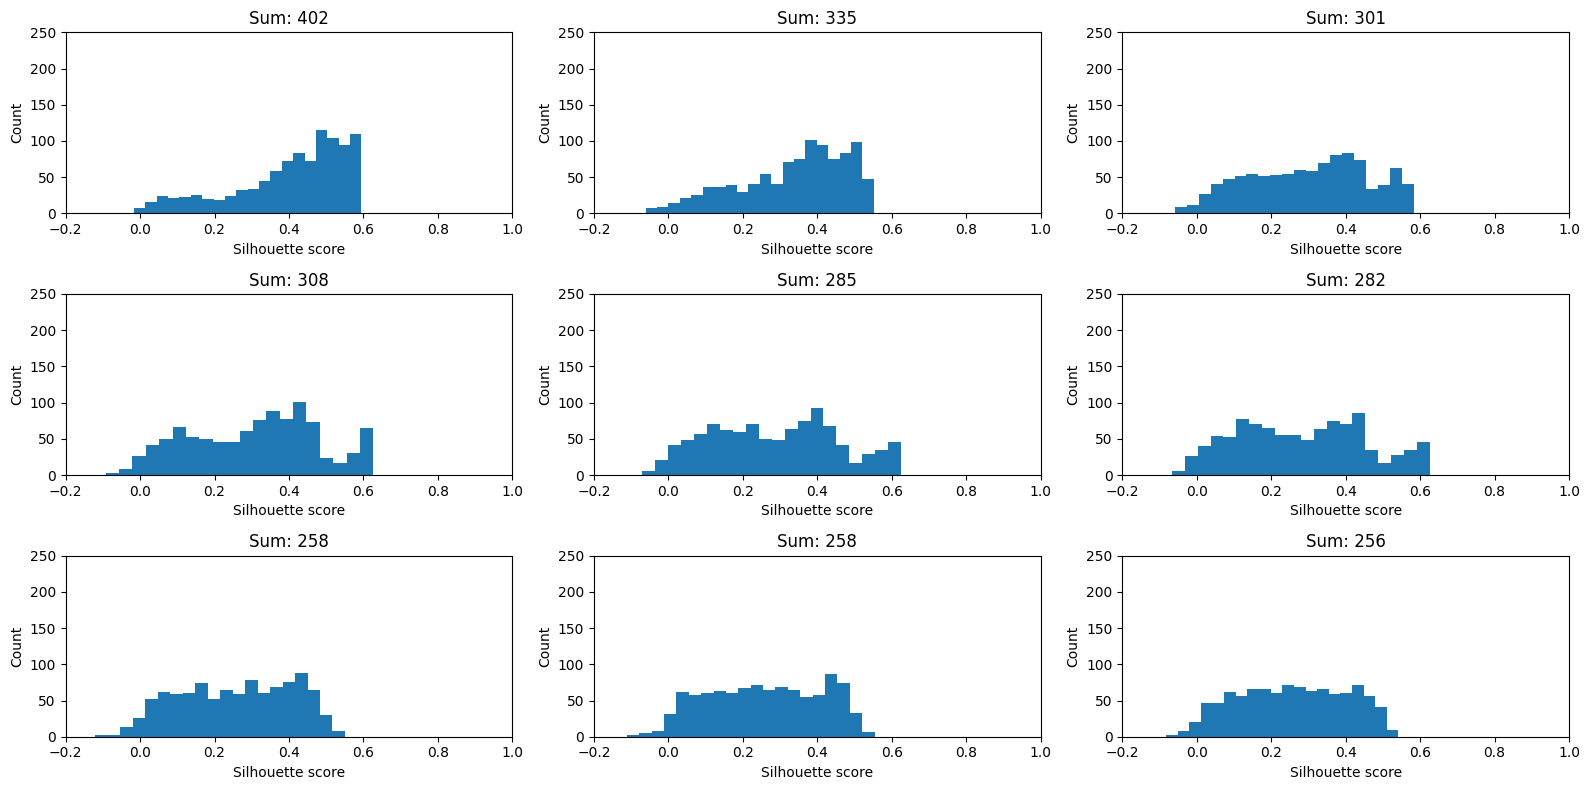

In [39]:
# using silhouette score to determine number of clusters
numClusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([numClusters, 1]) * np.NaN # init container to store sums

# Compute kMeans:
plt.figure(figsize = (16, 8))
for ii in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(ii)).fit(AUDL_transformed_reduced) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(AUDL_transformed_reduced, cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3, 3, ii-1) 
    plt.hist(s, bins = 20) 
    plt.xlim(-0.2, 1)
    plt.ylim(0, 250)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('Sum: {}'.format(int(Q[ii - 2]))) # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

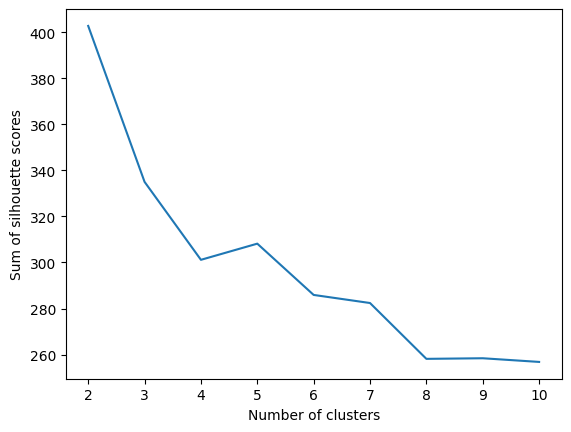

In [40]:
plt.plot(np.linspace(2,10,9),Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

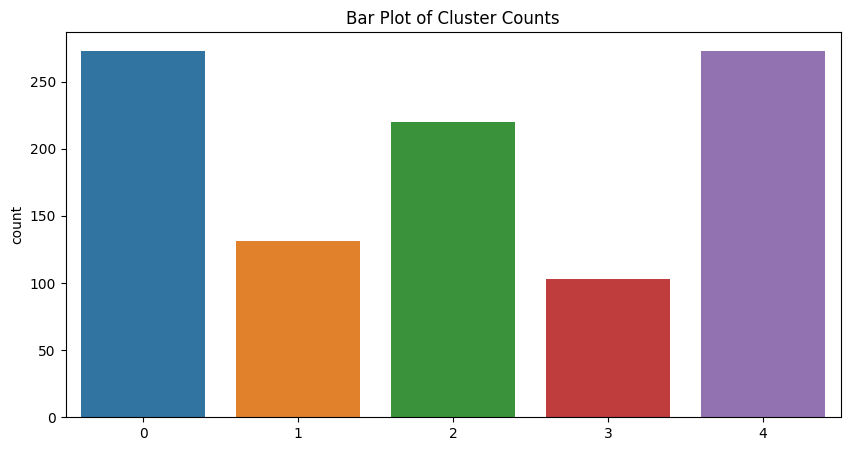

In [41]:
# Using a combination of elbow method and the silouhette score, we go for 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = rand_state)
kmeans.fit(AUDL_transformed_reduced)

cluster_labels = kmeans.labels_
AUDL_reduced['cluster'] = cluster_labels #AUDL player level data doesnt have labels
AUDL_reduced.to_csv('out.csv',index = True)

ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(cluster_labels)
title = "Bar Plot of Cluster Counts"
ax.set_title(title, fontsize = 12)
plt.show()

In [42]:
def vert_plot(vert_df,column,plot_title,y_label,x_label):
    # plot bar graph.
    index = tuple(vert_df.index)
    x_pos = np.arange(len(index))
    values = vert_df[column]
    title_size = 18
    f, ax = plt.subplots(nrows = 1, ncols = 1)  # declaring the figure and axis.
    f.set_size_inches(10, 10)  # setting the size of the figure.
    ax.bar(x_pos, values)
    ax.set_xticks(x_pos, labels = index)
    plt.tight_layout()
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    title = plt.title(plot_title, pad = 20, fontsize = title_size)
    plt.subplots_adjust(top = 0.8, bottom = 0.2, left = 0.1)
    ax.set_ylabel(y_label, color = '#525252')
    ax.set_xlabel(x_label, color = '#525252')
    plt.show()

In [43]:
# create function to build scatter plots.
def scatter_plot_nb(scat_df,column1,column2):
    scat_comb=scat_df[[column1,column2]]
    scat_comb.reset_index(inplace=True)
    df1 = scat_comb[scat_comb['cluster']==0]
    df2 = scat_comb[scat_comb['cluster']==1]
    df3 = scat_comb[scat_comb['cluster']==2]
    df4 = scat_comb[scat_comb['cluster']==3]
    ax = df1.plot(x=column1, y=column2, kind='scatter', c='r', label='Cluster 0')
    df2.plot(x=column1, y=column2, kind='scatter', ax=ax, c='g', label='Cluster 1')
    df3.plot(x=column1, y=column2, kind='scatter', ax=ax, c='orange', label='Cluster 2')
    df4.plot(x=column1, y=column2, kind='scatter', ax=ax, c='y', label='Cluster 3')
    plt.show()

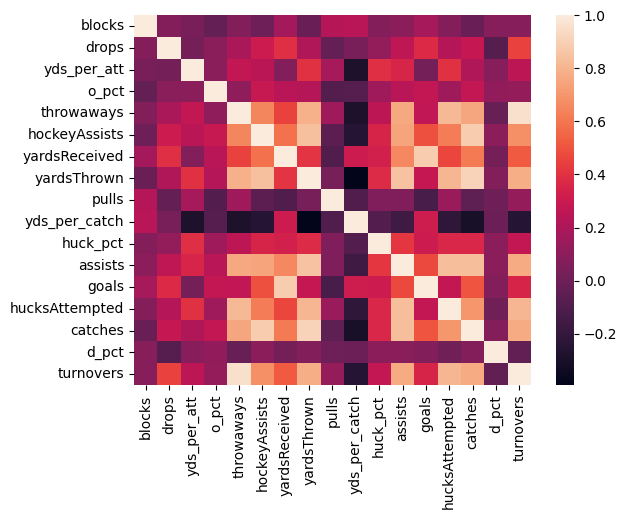

In [44]:
f_value_red = []
p_value_red = []
column_value_red =[]
for y in list(AUDL_reduced.columns):
    cluster_list = AUDL_reduced['cluster'].unique()
    f, p = stats.f_oneway(AUDL_reduced[(AUDL_reduced['cluster'] == cluster_list[0])][y],
                          AUDL_reduced[(AUDL_reduced['cluster'] == cluster_list[1])][y],
                          AUDL_reduced[(AUDL_reduced['cluster'] == cluster_list[2])][y],
                          AUDL_reduced[(AUDL_reduced['cluster'] == cluster_list[3])][y],
                          AUDL_reduced[(AUDL_reduced['cluster'] == cluster_list[4])][y],
                          )
    f_value_red.append(f)
    p_value_red.append(p)
    column_value_red.append(y)

d2 = {'Columns': column_value_red, 'p value': p_value_red}
col_clus_anova_red = pd.DataFrame(d2)
col_clus_anova_red.sort_values(by = ['p value'])

drop_reduced = ['oPointsScored', 'cluster', 'ovd']
AUDL_reduced_new = AUDL_reduced.drop(columns = drop_reduced)
corr_matrix = AUDL_reduced_new.corr()
sns.heatmap(corr_matrix)
plt.show()

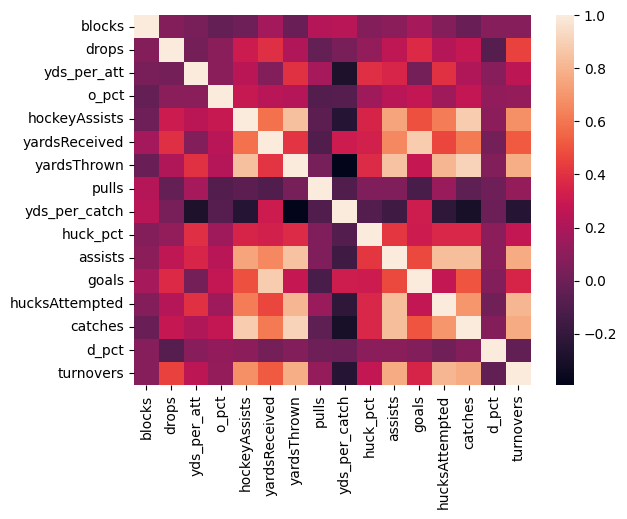

In [45]:
corr_matrix['max'] = corr_matrix.apply(lambda row: row.nlargest(2).values[-1], axis = 1)
drop_reduced_corr = ['throwaways'] #'goals', 'assists', 'hockeyAssists'
AUDL_reduced_final = AUDL_reduced_new.drop(columns = drop_reduced_corr) 

corr_matrix1 = AUDL_reduced_final.corr()
sns.heatmap(corr_matrix1)
plt.show()
corr_matrix1['max'] = corr_matrix1.apply(lambda row: row.nlargest(2).values[-1],axis = 1)

,Component,Explained Variance,Cumulative Explained Variance
0,1,0.443128,0.443128
1,2,0.179689,0.622816
2,3,0.095687,0.718503
3,4,0.072572,0.791075
4,5,0.053457,0.844532
5,6,0.034080,0.878612
6,7,0.028163,0.906775
7,8,0.021998,0.928772
8,9,0.020405,0.949178
9,10,0.015928,0.965106


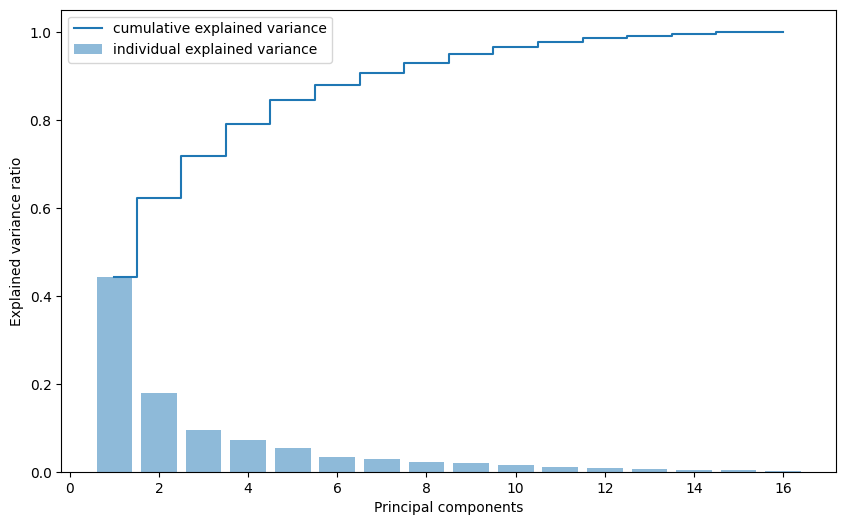

In [46]:
# k-means clustering to identify the clusters
scaler = MinMaxScaler()
AUDL_scaled_reduced_final = pd.DataFrame(scaler.fit_transform(AUDL_reduced_final))
AUDL_scaled_reduced_final.columns = AUDL_reduced_final.columns

n_components3 = AUDL_reduced_final.shape[1]
pca = PCA(n_components = n_components3, random_state = rand_state)
pca.fit(AUDL_scaled_reduced_final)

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
lst = []
for i in range (0, n_components3):
    lst.append([i + 1, round(explained_variance_ratio[i], 6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
display(pca_predictor)

plt.subplots(figsize = (10, 6))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align = 'center', alpha = 0.5, 
       label = 'individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where = 'mid',
         label = 'cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc = 'best')

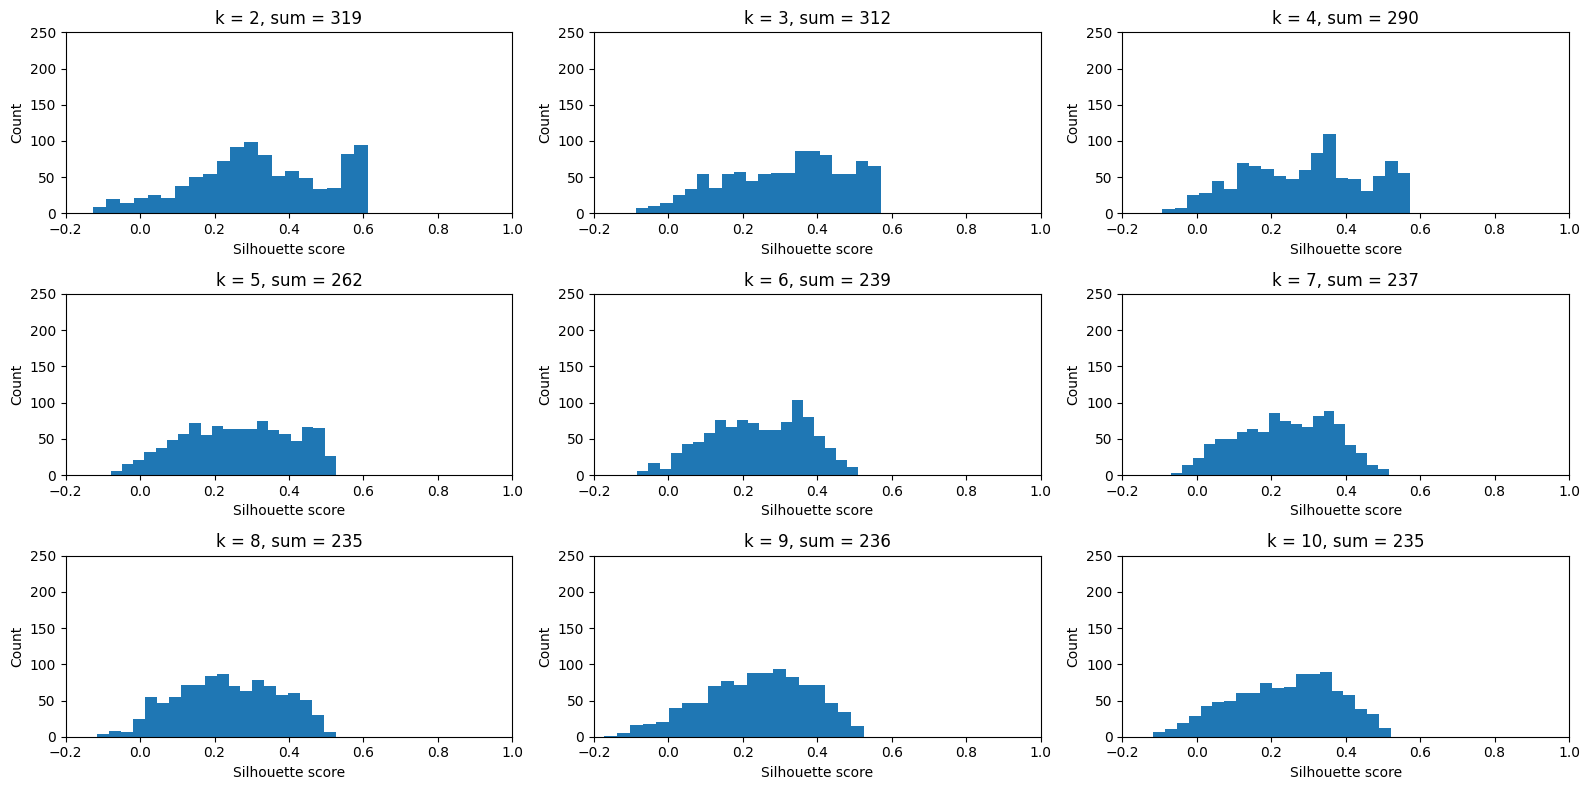

In [47]:
pca = PCA(n_components = 8, random_state = rand_state)
pca.fit(AUDL_scaled_reduced_final)
AUDL_transformed_reduced_final = pca.fit_transform(AUDL_scaled_reduced_final)

numClusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums

# Compute kMeans:
plt.figure(figsize = (16, 8))
for ii in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(ii)).fit(AUDL_transformed_reduced_final) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(AUDL_transformed_reduced_final,cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3,3, ii - 1) 
    plt.hist(s,bins = 20) 
    plt.xlim(-0.2, 1)
    plt.ylim(0, 250)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('k = {}, '.format(ii) + 'sum = {}'.format(int(Q[ii - 2])))
    plt.tight_layout() # adjusts subplot padding

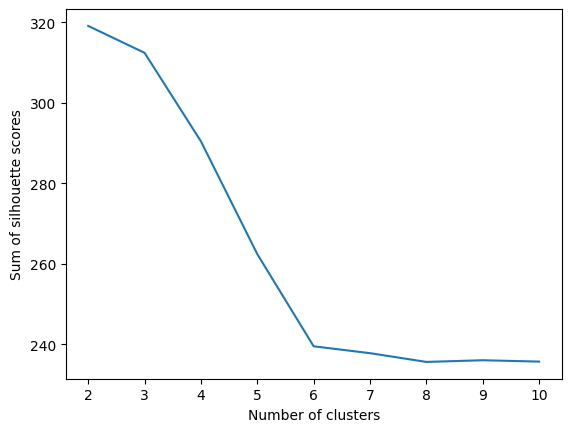

In [48]:
plt.plot(np.linspace(2, 10, 9), Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

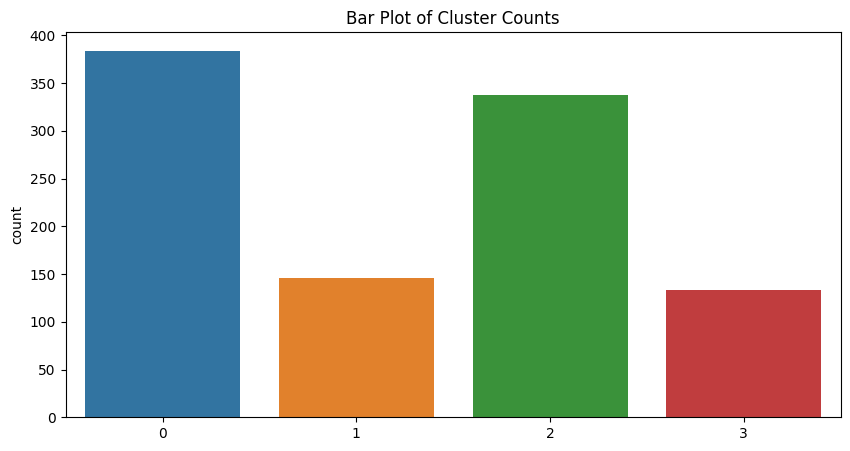

In [49]:
n_clusters = 4 # from our silouhette method
kmeans = KMeans(n_clusters = n_clusters, random_state = rand_state)
kmeans.fit(AUDL_transformed_reduced_final)

cluster_labels = kmeans.labels_
AUDL_reduced_final['cluster'] = cluster_labels #AUDL player level data doesnt have labels

ax = plt.subplots(figsize = (10, 5))
ax = sns.countplot(cluster_labels)
title = "Bar Plot of Cluster Counts"
ax.set_title(title, fontsize = 12)
plt.show()

In [50]:
AUDL_reduced_final.groupby('cluster').size()

cluster
0    384
1    146
2    337
3    133
dtype: int64

<AxesSubplot: xlabel='Attribute', ylabel='Value'>

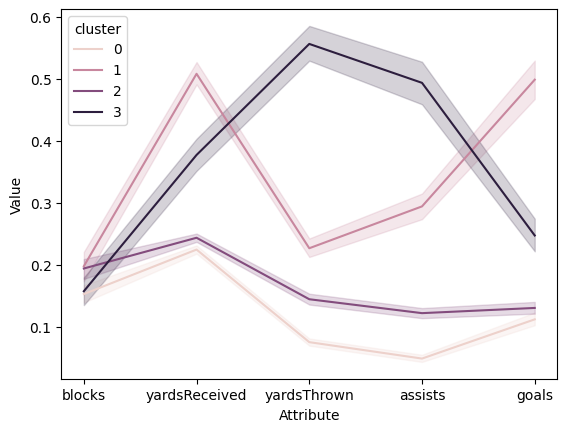

In [51]:
seg_summ1 = AUDL_reduced_final.groupby('cluster').agg('mean')

# Melt The Data
AUDL_scaled_reduced_final['cluster'] = cluster_labels
df_nor_melt = pd.melt(AUDL_scaled_reduced_final.reset_index(),
                      id_vars = ['index', 'cluster'],
                      value_vars = ['blocks', 'yardsReceived', 'yardsThrown', 'assists', 'goals'],
                      var_name = 'Attribute',
                      value_name = 'Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue = 'cluster', data = df_nor_melt)

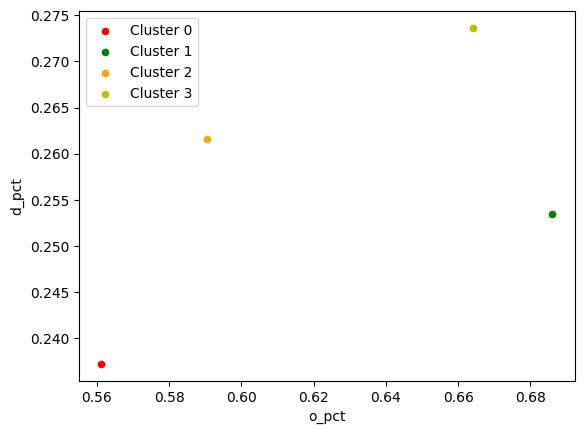

In [52]:
scatter_plot_nb(seg_summ1, 'o_pct', 'd_pct')

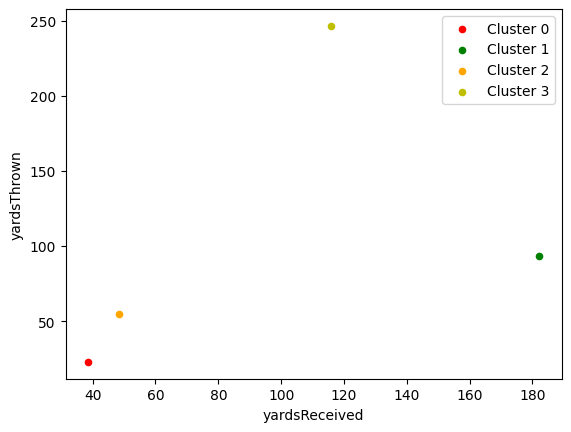

In [53]:
scatter_plot_nb(seg_summ1, 'yardsReceived', 'yardsThrown')

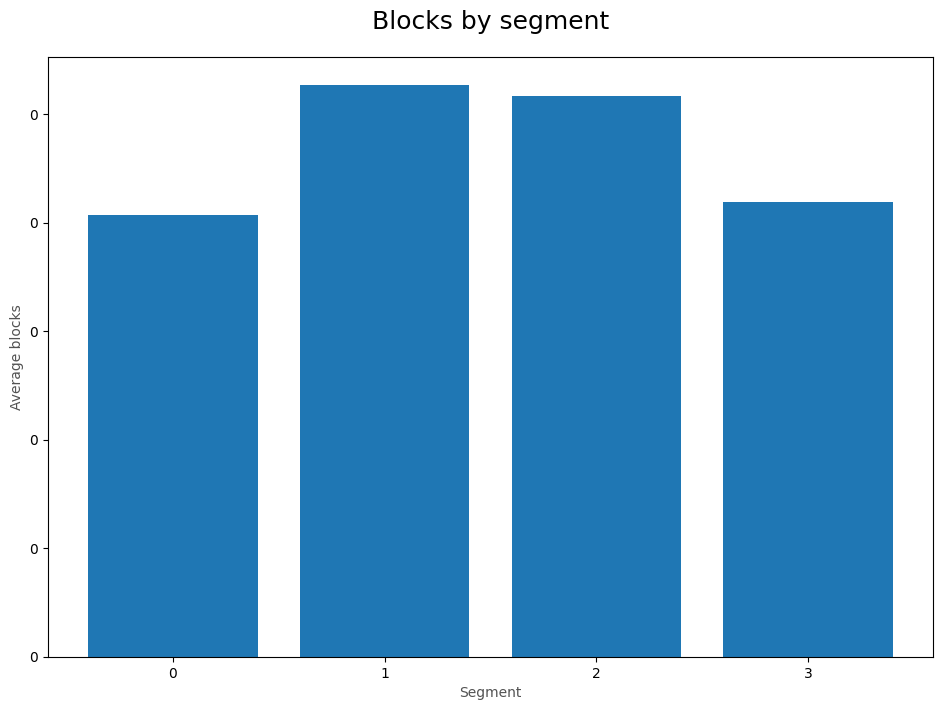

In [54]:
vert_plot(seg_summ1, 'blocks', 'Blocks by segment', 'Average blocks', 'Segment')

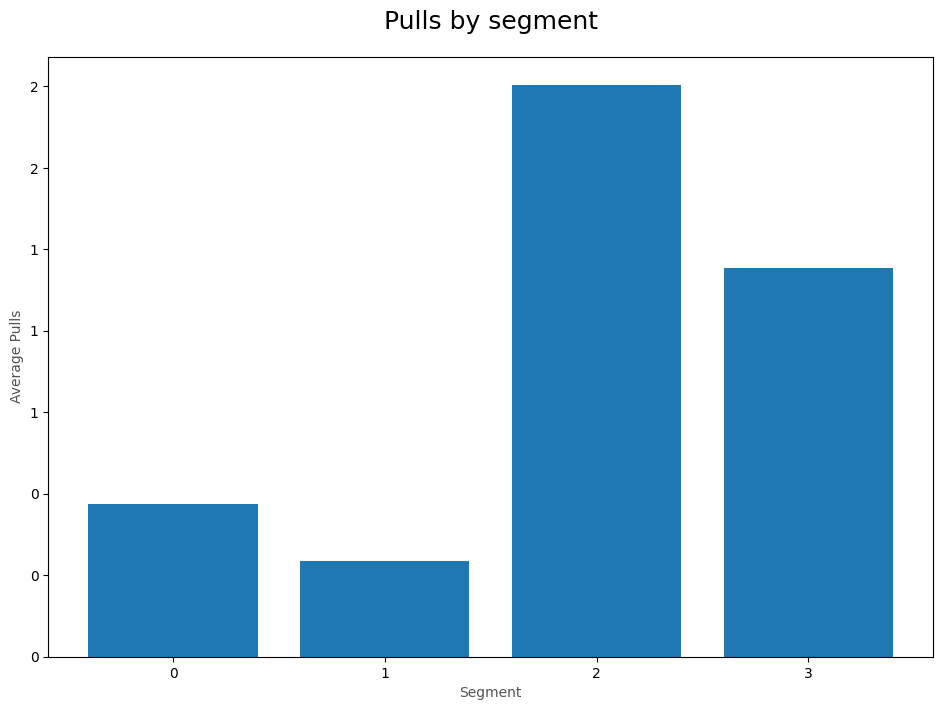

In [55]:
vert_plot(seg_summ1, 'pulls', 'Pulls by segment', 'Average Pulls', 'Segment')

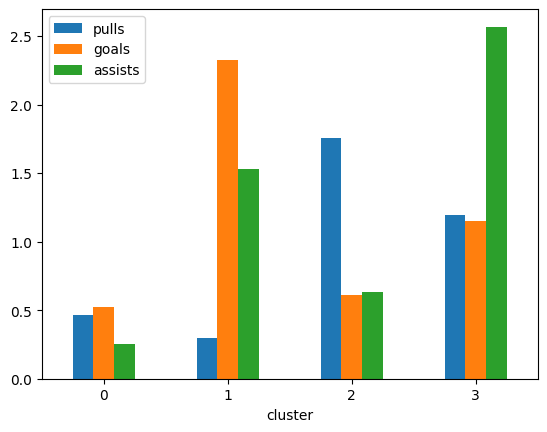

In [56]:
ax = seg_summ1.reset_index().plot(x = "cluster", y = ['pulls', 'goals', 'assists'], kind = 'bar', rot = 0)

# configure training & testing sets.
X = AUDL_reduced_final.loc[:, AUDL_reduced_final.columns != 'cluster']
y = AUDL_reduced_final.loc[:, AUDL_reduced_final.columns == 'cluster']
 
# train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rand_state)

In [57]:
best_alpha_logcv = [] 
precision_values_logcv = []
logcv_weight = []

x_mid = AUDL_reduced_final.loc[:, AUDL_reduced_final.columns != 'cluster']
y_mid = AUDL_reduced_final.loc[:, AUDL_reduced_final.columns == 'cluster']
x_train, x_test, y_train, y_test = train_test_split(x_mid, y_mid, test_size = 0.2, random_state = rand_state)
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
parameters = {'C': [10**-2, 10**-1, 10**0, 10**1, 10**2]}
# define the model/ estimator
scoring = {'AUC': 'roc_auc', 'Precision': 'average_precision', 'Recall': 'balanced_accuracy'}
model = LogisticRegression(random_state = rand_state, multi_class = 'multinomial', penalty = 'l2', solver = 'newton-cg')
# define the grid search
Log_reg = GridSearchCV(model, parameters, scoring = 'average_precision')
#fit the grid search
Log_reg.fit(x_train,y_train)

best_model_log = Log_reg.best_estimator_
best_model_log.fit(x_train,y_train)
best_alpha_logcv.append(best_model_log.C)

In [58]:
best_alpha_logcv[0]

0.01

In [59]:
# build model.
model1 = LogisticRegression(random_state = rand_state, multi_class = 'multinomial', penalty = 'l2',
                            solver = 'newton-cg', C = best_alpha_logcv[0]).fit(X_train, y_train)
preds = model1.predict(X_test)
# print the tunable parameters.
# (They were not tuned in this example, everything kept as default.)
params = model1.get_params()

In [60]:
# model parameters.
print('Intercept: \n', model1.intercept_)
print('Coefficients: \n', model1.coef_)

Intercept: 
 [ 10.19682927  -3.76225007   7.73665423 -14.17123343]
Coefficients: 
 [[-0.05771942  0.01758457 -0.1308171  -0.01180721  0.01227694 -0.03968864
  -0.05603744 -0.10327356  0.00930151 -0.55694384 -0.10119104 -0.00973603
  -0.12628092  0.02979287 -0.00974946 -0.00576566]
 [ 0.00840118  0.01133355  0.0584308   0.01127382  0.00803716  0.04115611
   0.00164715 -0.08595983  0.03228346  0.06395878 -0.02055901  0.08618579
  -0.01957463  0.00988051  0.01040349 -0.02838141]
 [ 0.0516816  -0.0324245  -0.00724848  0.00991326 -0.01619973 -0.02613227
  -0.01968093  0.05297165  0.0059638   0.50023699  0.03279287 -0.03119362
   0.05219656 -0.11562037 -0.00364083 -0.06984882]
 [-0.00236336  0.00350638  0.07963479 -0.00937988 -0.00411436  0.0246648
   0.07407122  0.13626174 -0.04754877 -0.00725193  0.08895717 -0.04525614
   0.09365899  0.07594699  0.00298681  0.10399589]]


In [61]:
# confusion matrix.
confusion_matrix(y_test, preds)

array([[66,  4,  5,  0],
       [ 0, 22,  1,  1],
       [17,  0, 61,  0],
       [ 0,  2,  1, 20]])

In [62]:
# accuracy.
print('Accuracy Score:', accuracy_score(y_test, preds))  
# create classification report.
class_report = classification_report(y_test, preds)
print(class_report)

Accuracy Score: 0.845
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        75
           1       0.79      0.92      0.85        24
           2       0.90      0.78      0.84        78
           3       0.95      0.87      0.91        23

    accuracy                           0.84       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.85      0.84      0.85       200



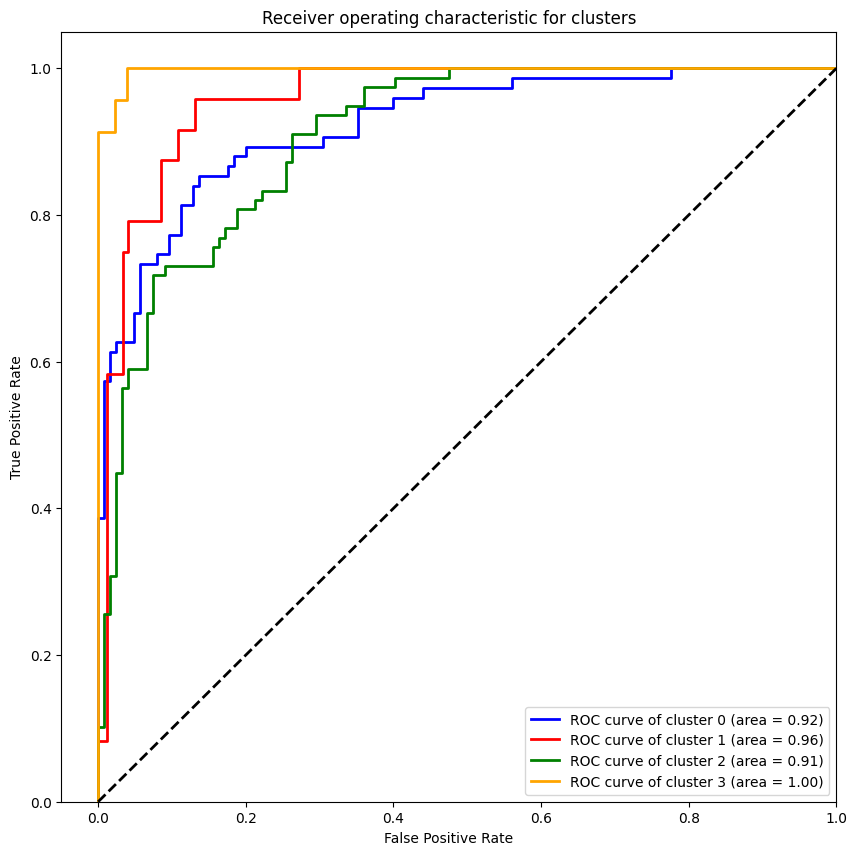

In [63]:
y1 = label_binarize(y_mid, classes=[0, 1, 2, 3])
n_classes = y1.shape[1]

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_mid, y1, test_size = 0.2, random_state = rand_state)

classifier = OneVsRestClassifier(model1)
y_score = classifier.fit(x_train1, y_train1).decision_function(x_test1)

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])
plt.subplots(figsize = (10, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2,
             label='ROC curve of cluster {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = lw)
plt.rcParams["figure.figsize"] = (6, 10)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for clusters')
plt.legend(loc = "lower right")
plt.show()